##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Object Detection with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) library to train a custom object detection model capable of detecting salads within images on a mobile device.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

You'll use the publicly available *Salads* dataset, which was created from the [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html).

Each image in the dataset contains objects labeled as one of the following classes:
* Baked Good
* Cheese
* Salad
* Seafood
* Tomato

The dataset contains the bounding-boxes specifying where each object locates, together with the object's label.

Here is an example image from the dataset:

<br/>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="0">




## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [2]:
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

Import the required packages.

In [3]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


### Prepare the dataset

Here you'll use the same dataset as the AutoML [quickstart](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset).

The *Salads* dataset is available at:
 `gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv`.

It contains 175 images for training, 25 images for validation, and 25 images for testing. The dataset has five classes: `Salad`, `Seafood`, `Tomato`, `Baked goods`, `Cheese`.

<br/>

The dataset is provided in CSV format:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data. You'll learn more about what that means in a later stage in this notebook.
* The three lines included here indicate **three distinct objects located inside the same image** available at `gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg`.
* Each row has a different label: `Salad`, `Seafood`, `Tomato`, etc.
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Here is a visualzation of these three lines:

<br>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="100">

If you want to know more about how to prepare your own CSV file and the minimum requirements for creating a valid dataset, see the [Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare) guide for more details.

If you are new to Google Cloud, you may wonder what the `gs://` URL means. They are URLs of files stored on [Google Cloud Storage](https://cloud.google.com/storage) (GCS). If you make your files on GCS public or [authenticate your client](https://cloud.google.com/storage/docs/authentication#libauth), Model Maker can read those files similarly to your local files.

However, you don't need to keep your images on Google Cloud to use Model Maker. You can use a local path in your CSV file and Model Maker will just work.

## Quickstart

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite0 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [4]:
spec = model_spec.get('efficientdet_lite0')

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `object_detector.DataLoader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [5]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [6]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/50


 1/21 [>.............................] - ETA: 12:51 - det_loss: 1.8787 - cls_loss: 1.1545 - box_loss: 0.0145 - reg_l2_loss: 0.0635 - loss: 1.9422 - learning_rate: 0.0080 - gradient_norm: 0.7864

 2/21 [=>............................] - ETA: 3s - det_loss: 1.8780 - cls_loss: 1.1515 - box_loss: 0.0145 - reg_l2_loss: 0.0635 - loss: 1.9416 - learning_rate: 0.0080 - gradient_norm: 0.7976   

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.8557 - cls_loss: 1.1484 - box_loss: 0.0141 - reg_l2_loss: 0.0635 - loss: 1.9193 - learning_rate: 0.0081 - gradient_norm: 0.8048

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.8443 - cls_loss: 1.1478 - box_loss: 0.0139 - reg_l2_loss: 0.0635 - loss: 1.9078 - learning_rate: 0.0081 - gradient_norm: 0.7840

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.8332 - cls_loss: 1.1458 - box_loss: 0.0137 - reg_l2_loss: 0.0635 - loss: 1.8968 - learning_rate: 0.0082 - gradient_norm: 0.7635

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.8317 - cls_loss: 1.1472 - box_loss: 0.0137 - reg_l2_loss: 0.0635 - loss: 1.8952 - learning_rate: 0.0082 - gradient_norm: 0.8329

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.8254 - cls_loss: 1.1457 - box_loss: 0.0136 - reg_l2_loss: 0.0635 - loss: 1.8889 - learning_rate: 0.0083 - gradient_norm: 0.7990

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.8169 - cls_loss: 1.1459 - box_loss: 0.0134 - reg_l2_loss: 0.0635 - loss: 1.8805 - learning_rate: 0.0083 - gradient_norm: 0.8195

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.8175 - cls_loss: 1.1441 - box_loss: 0.0135 - reg_l2_loss: 0.0635 - loss: 1.8810 - learning_rate: 0.0084 - gradient_norm: 0.7982

10/21 [=============>................] - ETA: 1s - det_loss: 1.8142 - cls_loss: 1.1430 - box_loss: 0.0134 - reg_l2_loss: 0.0635 - loss: 1.8777 - learning_rate: 0.0084 - gradient_norm: 0.7854

11/21 [==============>...............] - ETA: 1s - det_loss: 1.8066 - cls_loss: 1.1420 - box_loss: 0.0133 - reg_l2_loss: 0.0635 - loss: 1.8701 - learning_rate: 0.0085 - gradient_norm: 0.7873

12/21 [================>.............] - ETA: 1s - det_loss: 1.8025 - cls_loss: 1.1425 - box_loss: 0.0132 - reg_l2_loss: 0.0635 - loss: 1.8661 - learning_rate: 0.0085 - gradient_norm: 0.7851

13/21 [=================>............] - ETA: 1s - det_loss: 1.8023 - cls_loss: 1.1414 - box_loss: 0.0132 - reg_l2_loss: 0.0635 - loss: 1.8659 - learning_rate: 0.0086 - gradient_norm: 0.7826

14/21 [===================>..........] - ETA: 1s - det_loss: 1.7980 - cls_loss: 1.1411 - box_loss: 0.0131 - reg_l2_loss: 0.0635 - loss: 1.8615 - learning_rate: 0.0086 - gradient_norm: 0.7750

15/21 [====================>.........] - ETA: 0s - det_loss: 1.7965 - cls_loss: 1.1407 - box_loss: 0.0131 - reg_l2_loss: 0.0635 - loss: 1.8601 - learning_rate: 0.0087 - gradient_norm: 0.7704

16/21 [=====================>........] - ETA: 0s - det_loss: 1.7902 - cls_loss: 1.1401 - box_loss: 0.0130 - reg_l2_loss: 0.0635 - loss: 1.8537 - learning_rate: 0.0087 - gradient_norm: 0.7647

17/21 [=======================>......] - ETA: 0s - det_loss: 1.7848 - cls_loss: 1.1391 - box_loss: 0.0129 - reg_l2_loss: 0.0635 - loss: 1.8483 - learning_rate: 0.0088 - gradient_norm: 0.7587

18/21 [========================>.....] - ETA: 0s - det_loss: 1.7792 - cls_loss: 1.1384 - box_loss: 0.0128 - reg_l2_loss: 0.0635 - loss: 1.8428 - learning_rate: 0.0088 - gradient_norm: 0.7576

19/21 [==========================>...] - ETA: 0s - det_loss: 1.7758 - cls_loss: 1.1376 - box_loss: 0.0128 - reg_l2_loss: 0.0635 - loss: 1.8393 - learning_rate: 0.0089 - gradient_norm: 0.7547

20/21 [===========================>..] - ETA: 0s - det_loss: 1.7705 - cls_loss: 1.1368 - box_loss: 0.0127 - reg_l2_loss: 0.0635 - loss: 1.8340 - learning_rate: 0.0089 - gradient_norm: 0.7466

21/21 [==============================] - ETA: 0s - det_loss: 1.7663 - cls_loss: 1.1359 - box_loss: 0.0126 - reg_l2_loss: 0.0635 - loss: 1.8298 - learning_rate: 0.0090 - gradient_norm: 0.7434

21/21 [==============================] - 48s 455ms/step - det_loss: 1.7625 - cls_loss: 1.1351 - box_loss: 0.0125 - reg_l2_loss: 0.0635 - loss: 1.8260 - learning_rate: 0.0090 - gradient_norm: 0.7406 - val_det_loss: 1.6586 - val_cls_loss: 1.1076 - val_box_loss: 0.0110 - val_reg_l2_loss: 0.0635 - val_loss: 1.7221


Epoch 2/50
 1/21 [>.............................] - ETA: 3s - det_loss: 1.6445 - cls_loss: 1.1162 - box_loss: 0.0106 - reg_l2_loss: 0.0635 - loss: 1.7081 - learning_rate: 0.0100 - gradient_norm: 0.6357

 2/21 [=>............................] - ETA: 3s - det_loss: 1.6407 - cls_loss: 1.1149 - box_loss: 0.0105 - reg_l2_loss: 0.0635 - loss: 1.7042 - learning_rate: 0.0100 - gradient_norm: 0.6631

 3/21 [===>..........................] - ETA: 3s - det_loss: 1.6593 - cls_loss: 1.1158 - box_loss: 0.0109 - reg_l2_loss: 0.0635 - loss: 1.7228 - learning_rate: 0.0100 - gradient_norm: 0.7389

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.6639 - cls_loss: 1.1160 - box_loss: 0.0110 - reg_l2_loss: 0.0635 - loss: 1.7275 - learning_rate: 0.0100 - gradient_norm: 0.7830

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.6677 - cls_loss: 1.1159 - box_loss: 0.0110 - reg_l2_loss: 0.0635 - loss: 1.7313 - learning_rate: 0.0100 - gradient_norm: 0.7821

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.6604 - cls_loss: 1.1136 - box_loss: 0.0109 - reg_l2_loss: 0.0635 - loss: 1.7239 - learning_rate: 0.0100 - gradient_norm: 0.8107

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.6566 - cls_loss: 1.1125 - box_loss: 0.0109 - reg_l2_loss: 0.0635 - loss: 1.7201 - learning_rate: 0.0100 - gradient_norm: 0.8030

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.6589 - cls_loss: 1.1123 - box_loss: 0.0109 - reg_l2_loss: 0.0635 - loss: 1.7225 - learning_rate: 0.0100 - gradient_norm: 0.8133

 9/21 [===========>..................] - ETA: 2s - det_loss: 1.6570 - cls_loss: 1.1111 - box_loss: 0.0109 - reg_l2_loss: 0.0635 - loss: 1.7205 - learning_rate: 0.0100 - gradient_norm: 0.8069

10/21 [=============>................] - ETA: 1s - det_loss: 1.6534 - cls_loss: 1.1094 - box_loss: 0.0109 - reg_l2_loss: 0.0635 - loss: 1.7169 - learning_rate: 0.0100 - gradient_norm: 0.8070

11/21 [==============>...............] - ETA: 1s - det_loss: 1.6496 - cls_loss: 1.1079 - box_loss: 0.0108 - reg_l2_loss: 0.0635 - loss: 1.7131 - learning_rate: 0.0100 - gradient_norm: 0.8128

12/21 [================>.............] - ETA: 1s - det_loss: 1.6438 - cls_loss: 1.1064 - box_loss: 0.0107 - reg_l2_loss: 0.0635 - loss: 1.7073 - learning_rate: 0.0100 - gradient_norm: 0.8168

13/21 [=================>............] - ETA: 1s - det_loss: 1.6441 - cls_loss: 1.1062 - box_loss: 0.0108 - reg_l2_loss: 0.0635 - loss: 1.7076 - learning_rate: 0.0100 - gradient_norm: 0.8295

14/21 [===================>..........] - ETA: 1s - det_loss: 1.6420 - cls_loss: 1.1052 - box_loss: 0.0107 - reg_l2_loss: 0.0635 - loss: 1.7055 - learning_rate: 0.0100 - gradient_norm: 0.8191

15/21 [====================>.........] - ETA: 1s - det_loss: 1.6352 - cls_loss: 1.1033 - box_loss: 0.0106 - reg_l2_loss: 0.0635 - loss: 1.6987 - learning_rate: 0.0100 - gradient_norm: 0.8204

16/21 [=====================>........] - ETA: 1s - det_loss: 1.6329 - cls_loss: 1.1029 - box_loss: 0.0106 - reg_l2_loss: 0.0635 - loss: 1.6964 - learning_rate: 0.0100 - gradient_norm: 0.8311

17/21 [=======================>......] - ETA: 1s - det_loss: 1.6325 - cls_loss: 1.1007 - box_loss: 0.0106 - reg_l2_loss: 0.0635 - loss: 1.6960 - learning_rate: 0.0100 - gradient_norm: 0.8378

18/21 [========================>.....] - ETA: 0s - det_loss: 1.6288 - cls_loss: 1.0991 - box_loss: 0.0106 - reg_l2_loss: 0.0635 - loss: 1.6923 - learning_rate: 0.0100 - gradient_norm: 0.8341

19/21 [==========================>...] - ETA: 0s - det_loss: 1.6337 - cls_loss: 1.0977 - box_loss: 0.0107 - reg_l2_loss: 0.0635 - loss: 1.6972 - learning_rate: 0.0100 - gradient_norm: 0.8412

20/21 [===========================>..] - ETA: 0s - det_loss: 1.6292 - cls_loss: 1.0958 - box_loss: 0.0107 - reg_l2_loss: 0.0635 - loss: 1.6928 - learning_rate: 0.0100 - gradient_norm: 0.8441

21/21 [==============================] - ETA: 0s - det_loss: 1.6257 - cls_loss: 1.0946 - box_loss: 0.0106 - reg_l2_loss: 0.0635 - loss: 1.6892 - learning_rate: 0.0100 - gradient_norm: 0.8416

21/21 [==============================] - 9s 452ms/step - det_loss: 1.6224 - cls_loss: 1.0936 - box_loss: 0.0106 - reg_l2_loss: 0.0635 - loss: 1.6860 - learning_rate: 0.0100 - gradient_norm: 0.8392 - val_det_loss: 1.5282 - val_cls_loss: 1.0231 - val_box_loss: 0.0101 - val_reg_l2_loss: 0.0635 - val_loss: 1.5917


Epoch 3/50
 1/21 [>.............................] - ETA: 3s - det_loss: 1.5260 - cls_loss: 1.0566 - box_loss: 0.0094 - reg_l2_loss: 0.0635 - loss: 1.5895 - learning_rate: 0.0100 - gradient_norm: 0.9677

 2/21 [=>............................] - ETA: 2s - det_loss: 1.5219 - cls_loss: 1.0522 - box_loss: 0.0094 - reg_l2_loss: 0.0635 - loss: 1.5854 - learning_rate: 0.0100 - gradient_norm: 0.9166

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.5777 - cls_loss: 1.0664 - box_loss: 0.0102 - reg_l2_loss: 0.0635 - loss: 1.6413 - learning_rate: 0.0100 - gradient_norm: 0.9918

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.5704 - cls_loss: 1.0609 - box_loss: 0.0102 - reg_l2_loss: 0.0635 - loss: 1.6339 - learning_rate: 0.0100 - gradient_norm: 1.0107

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.5590 - cls_loss: 1.0560 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.6225 - learning_rate: 0.0100 - gradient_norm: 1.0596

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.5478 - cls_loss: 1.0517 - box_loss: 0.0099 - reg_l2_loss: 0.0635 - loss: 1.6114 - learning_rate: 0.0100 - gradient_norm: 1.0678

 7/21 [=========>....................] - ETA: 3s - det_loss: 1.5499 - cls_loss: 1.0504 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.6134 - learning_rate: 0.0100 - gradient_norm: 1.0754

 8/21 [==========>...................] - ETA: 3s - det_loss: 1.5379 - cls_loss: 1.0468 - box_loss: 0.0098 - reg_l2_loss: 0.0635 - loss: 1.6015 - learning_rate: 0.0100 - gradient_norm: 1.1337

 9/21 [===========>..................] - ETA: 3s - det_loss: 1.5345 - cls_loss: 1.0445 - box_loss: 0.0098 - reg_l2_loss: 0.0635 - loss: 1.5980 - learning_rate: 0.0100 - gradient_norm: 1.1481

10/21 [=============>................] - ETA: 4s - det_loss: 1.5265 - cls_loss: 1.0390 - box_loss: 0.0097 - reg_l2_loss: 0.0635 - loss: 1.5900 - learning_rate: 0.0099 - gradient_norm: 1.1388

11/21 [==============>...............] - ETA: 3s - det_loss: 1.5173 - cls_loss: 1.0356 - box_loss: 0.0096 - reg_l2_loss: 0.0635 - loss: 1.5809 - learning_rate: 0.0099 - gradient_norm: 1.1509

12/21 [================>.............] - ETA: 3s - det_loss: 1.5096 - cls_loss: 1.0313 - box_loss: 0.0096 - reg_l2_loss: 0.0635 - loss: 1.5732 - learning_rate: 0.0099 - gradient_norm: 1.1467

13/21 [=================>............] - ETA: 2s - det_loss: 1.5021 - cls_loss: 1.0276 - box_loss: 0.0095 - reg_l2_loss: 0.0635 - loss: 1.5657 - learning_rate: 0.0099 - gradient_norm: 1.1350

14/21 [===================>..........] - ETA: 2s - det_loss: 1.4983 - cls_loss: 1.0226 - box_loss: 0.0095 - reg_l2_loss: 0.0635 - loss: 1.5618 - learning_rate: 0.0099 - gradient_norm: 1.1391

15/21 [====================>.........] - ETA: 1s - det_loss: 1.4981 - cls_loss: 1.0209 - box_loss: 0.0095 - reg_l2_loss: 0.0635 - loss: 1.5617 - learning_rate: 0.0099 - gradient_norm: 1.1919

16/21 [=====================>........] - ETA: 1s - det_loss: 1.4951 - cls_loss: 1.0192 - box_loss: 0.0095 - reg_l2_loss: 0.0635 - loss: 1.5587 - learning_rate: 0.0099 - gradient_norm: 1.2364

17/21 [=======================>......] - ETA: 1s - det_loss: 1.4900 - cls_loss: 1.0157 - box_loss: 0.0095 - reg_l2_loss: 0.0635 - loss: 1.5536 - learning_rate: 0.0099 - gradient_norm: 1.2599

18/21 [========================>.....] - ETA: 1s - det_loss: 1.4882 - cls_loss: 1.0112 - box_loss: 0.0095 - reg_l2_loss: 0.0635 - loss: 1.5517 - learning_rate: 0.0099 - gradient_norm: 1.2500

19/21 [==========================>...] - ETA: 0s - det_loss: 1.4804 - cls_loss: 1.0068 - box_loss: 0.0095 - reg_l2_loss: 0.0635 - loss: 1.5439 - learning_rate: 0.0099 - gradient_norm: 1.2604

20/21 [===========================>..] - ETA: 0s - det_loss: 1.4842 - cls_loss: 1.0042 - box_loss: 0.0096 - reg_l2_loss: 0.0635 - loss: 1.5478 - learning_rate: 0.0099 - gradient_norm: 1.2825

21/21 [==============================] - ETA: 0s - det_loss: 1.4838 - cls_loss: 1.0036 - box_loss: 0.0096 - reg_l2_loss: 0.0635 - loss: 1.5473 - learning_rate: 0.0099 - gradient_norm: 1.3457

21/21 [==============================] - 11s 566ms/step - det_loss: 1.4834 - cls_loss: 1.0031 - box_loss: 0.0096 - reg_l2_loss: 0.0635 - loss: 1.5469 - learning_rate: 0.0099 - gradient_norm: 1.4031 - val_det_loss: 1.7022 - val_cls_loss: 1.2259 - val_box_loss: 0.0095 - val_reg_l2_loss: 0.0636 - val_loss: 1.7657


Epoch 4/50
 1/21 [>.............................] - ETA: 2s - det_loss: 1.2639 - cls_loss: 0.8598 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.3274 - learning_rate: 0.0099 - gradient_norm: 1.8835

 2/21 [=>............................] - ETA: 3s - det_loss: 1.2606 - cls_loss: 0.8656 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.3242 - learning_rate: 0.0099 - gradient_norm: 1.6069

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.2954 - cls_loss: 0.8768 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.3590 - learning_rate: 0.0099 - gradient_norm: 1.6647

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.2933 - cls_loss: 0.8743 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.3569 - learning_rate: 0.0099 - gradient_norm: 1.6850

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.2860 - cls_loss: 0.8730 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.3496 - learning_rate: 0.0099 - gradient_norm: 1.7448

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.2923 - cls_loss: 0.8713 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.3558 - learning_rate: 0.0099 - gradient_norm: 1.6513

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.2984 - cls_loss: 0.8668 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.3619 - learning_rate: 0.0099 - gradient_norm: 1.5683

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.2982 - cls_loss: 0.8610 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.3617 - learning_rate: 0.0099 - gradient_norm: 1.5821

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.3069 - cls_loss: 0.8685 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.3705 - learning_rate: 0.0099 - gradient_norm: 1.6173

10/21 [=============>................] - ETA: 1s - det_loss: 1.3034 - cls_loss: 0.8683 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.3669 - learning_rate: 0.0099 - gradient_norm: 1.6568

11/21 [==============>...............] - ETA: 2s - det_loss: 1.3132 - cls_loss: 0.8677 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.3768 - learning_rate: 0.0099 - gradient_norm: 1.7188

12/21 [================>.............] - ETA: 2s - det_loss: 1.3228 - cls_loss: 0.8777 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.3864 - learning_rate: 0.0099 - gradient_norm: 1.8490

13/21 [=================>............] - ETA: 2s - det_loss: 1.3196 - cls_loss: 0.8735 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.3832 - learning_rate: 0.0099 - gradient_norm: 1.8129

14/21 [===================>..........] - ETA: 1s - det_loss: 1.3090 - cls_loss: 0.8673 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.3726 - learning_rate: 0.0099 - gradient_norm: 1.7815

15/21 [====================>.........] - ETA: 1s - det_loss: 1.3087 - cls_loss: 0.8633 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.3723 - learning_rate: 0.0099 - gradient_norm: 1.7502

16/21 [=====================>........] - ETA: 1s - det_loss: 1.2975 - cls_loss: 0.8551 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.3611 - learning_rate: 0.0099 - gradient_norm: 1.7730

17/21 [=======================>......] - ETA: 1s - det_loss: 1.2933 - cls_loss: 0.8498 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.3569 - learning_rate: 0.0099 - gradient_norm: 1.7475

18/21 [========================>.....] - ETA: 1s - det_loss: 1.2902 - cls_loss: 0.8492 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.3537 - learning_rate: 0.0099 - gradient_norm: 1.7769

19/21 [==========================>...] - ETA: 0s - det_loss: 1.2918 - cls_loss: 0.8529 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.3553 - learning_rate: 0.0099 - gradient_norm: 1.8099

20/21 [===========================>..] - ETA: 0s - det_loss: 1.2857 - cls_loss: 0.8492 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.3493 - learning_rate: 0.0099 - gradient_norm: 1.7767

21/21 [==============================] - ETA: 0s - det_loss: 1.2879 - cls_loss: 0.8479 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.3514 - learning_rate: 0.0099 - gradient_norm: 1.7974

21/21 [==============================] - 11s 541ms/step - det_loss: 1.2898 - cls_loss: 0.8467 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.3534 - learning_rate: 0.0099 - gradient_norm: 1.8163 - val_det_loss: 1.5550 - val_cls_loss: 1.1171 - val_box_loss: 0.0088 - val_reg_l2_loss: 0.0636 - val_loss: 1.6185


Epoch 5/50
 1/21 [>.............................] - ETA: 2s - det_loss: 1.3446 - cls_loss: 0.8923 - box_loss: 0.0090 - reg_l2_loss: 0.0636 - loss: 1.4081 - learning_rate: 0.0098 - gradient_norm: 1.6056

 2/21 [=>............................] - ETA: 2s - det_loss: 1.2515 - cls_loss: 0.8440 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.3151 - learning_rate: 0.0098 - gradient_norm: 1.7535

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.2444 - cls_loss: 0.8306 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.3080 - learning_rate: 0.0098 - gradient_norm: 1.7612

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.2514 - cls_loss: 0.8320 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.3149 - learning_rate: 0.0098 - gradient_norm: 1.6091

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.2480 - cls_loss: 0.8311 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.3116 - learning_rate: 0.0098 - gradient_norm: 1.6337

 6/21 [=======>......................] - ETA: 3s - det_loss: 1.2387 - cls_loss: 0.8268 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.3023 - learning_rate: 0.0098 - gradient_norm: 1.8401

 7/21 [=========>....................] - ETA: 3s - det_loss: 1.2426 - cls_loss: 0.8301 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.3062 - learning_rate: 0.0098 - gradient_norm: 1.8160

 8/21 [==========>...................] - ETA: 3s - det_loss: 1.2017 - cls_loss: 0.8027 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.2653 - learning_rate: 0.0098 - gradient_norm: 1.8141

 9/21 [===========>..................] - ETA: 4s - det_loss: 1.1907 - cls_loss: 0.7902 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.2542 - learning_rate: 0.0098 - gradient_norm: 1.7555

10/21 [=============>................] - ETA: 4s - det_loss: 1.1877 - cls_loss: 0.7823 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.2512 - learning_rate: 0.0098 - gradient_norm: 1.7427

11/21 [==============>...............] - ETA: 4s - det_loss: 1.1814 - cls_loss: 0.7783 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.2450 - learning_rate: 0.0098 - gradient_norm: 1.7655

12/21 [================>.............] - ETA: 4s - det_loss: 1.1727 - cls_loss: 0.7685 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.2362 - learning_rate: 0.0098 - gradient_norm: 1.7660

13/21 [=================>............] - ETA: 3s - det_loss: 1.1754 - cls_loss: 0.7681 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.2390 - learning_rate: 0.0098 - gradient_norm: 1.7347

14/21 [===================>..........] - ETA: 3s - det_loss: 1.1681 - cls_loss: 0.7644 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.2316 - learning_rate: 0.0098 - gradient_norm: 1.7450

15/21 [====================>.........] - ETA: 2s - det_loss: 1.1608 - cls_loss: 0.7587 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.2243 - learning_rate: 0.0098 - gradient_norm: 1.7273

16/21 [=====================>........] - ETA: 2s - det_loss: 1.1564 - cls_loss: 0.7577 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.2199 - learning_rate: 0.0098 - gradient_norm: 1.7736

17/21 [=======================>......] - ETA: 1s - det_loss: 1.1527 - cls_loss: 0.7536 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.2163 - learning_rate: 0.0098 - gradient_norm: 1.7502

18/21 [========================>.....] - ETA: 1s - det_loss: 1.1424 - cls_loss: 0.7455 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.2059 - learning_rate: 0.0098 - gradient_norm: 1.7400

19/21 [==========================>...] - ETA: 0s - det_loss: 1.1332 - cls_loss: 0.7389 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1967 - learning_rate: 0.0098 - gradient_norm: 1.7193

20/21 [===========================>..] - ETA: 0s - det_loss: 1.1264 - cls_loss: 0.7347 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.1900 - learning_rate: 0.0098 - gradient_norm: 1.7067

21/21 [==============================] - ETA: 0s - det_loss: 1.1268 - cls_loss: 0.7330 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1904 - learning_rate: 0.0098 - gradient_norm: 1.7088

21/21 [==============================] - 20s 970ms/step - det_loss: 1.1272 - cls_loss: 0.7315 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1908 - learning_rate: 0.0098 - gradient_norm: 1.7106 - val_det_loss: 1.4876 - val_cls_loss: 1.0551 - val_box_loss: 0.0087 - val_reg_l2_loss: 0.0636 - val_loss: 1.5512


Epoch 6/50
 1/21 [>.............................] - ETA: 3s - det_loss: 1.0008 - cls_loss: 0.6325 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0643 - learning_rate: 0.0097 - gradient_norm: 1.4727

 2/21 [=>............................] - ETA: 3s - det_loss: 1.0538 - cls_loss: 0.6594 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1174 - learning_rate: 0.0097 - gradient_norm: 1.6325

 3/21 [===>..........................] - ETA: 3s - det_loss: 1.0557 - cls_loss: 0.6709 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1193 - learning_rate: 0.0097 - gradient_norm: 1.5949

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.0523 - cls_loss: 0.6490 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1159 - learning_rate: 0.0097 - gradient_norm: 1.5803

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.0145 - cls_loss: 0.6221 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.0780 - learning_rate: 0.0097 - gradient_norm: 1.5259

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.0246 - cls_loss: 0.6391 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0882 - learning_rate: 0.0097 - gradient_norm: 1.5637

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.0477 - cls_loss: 0.6611 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1113 - learning_rate: 0.0097 - gradient_norm: 1.5962

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.0403 - cls_loss: 0.6553 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1039 - learning_rate: 0.0097 - gradient_norm: 1.5805

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.0506 - cls_loss: 0.6649 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1141 - learning_rate: 0.0097 - gradient_norm: 1.6339

10/21 [=============>................] - ETA: 1s - det_loss: 1.0545 - cls_loss: 0.6674 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1181 - learning_rate: 0.0097 - gradient_norm: 1.6713

11/21 [==============>...............] - ETA: 1s - det_loss: 1.0539 - cls_loss: 0.6703 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1175 - learning_rate: 0.0097 - gradient_norm: 1.7121

12/21 [================>.............] - ETA: 1s - det_loss: 1.0586 - cls_loss: 0.6771 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1222 - learning_rate: 0.0097 - gradient_norm: 1.7654

13/21 [=================>............] - ETA: 1s - det_loss: 1.0688 - cls_loss: 0.6808 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.1324 - learning_rate: 0.0097 - gradient_norm: 1.8205

14/21 [===================>..........] - ETA: 1s - det_loss: 1.0739 - cls_loss: 0.6843 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.1375 - learning_rate: 0.0097 - gradient_norm: 1.8025

15/21 [====================>.........] - ETA: 0s - det_loss: 1.0708 - cls_loss: 0.6841 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1344 - learning_rate: 0.0097 - gradient_norm: 1.7980

16/21 [=====================>........] - ETA: 0s - det_loss: 1.0701 - cls_loss: 0.6847 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1337 - learning_rate: 0.0097 - gradient_norm: 1.8804

17/21 [=======================>......] - ETA: 0s - det_loss: 1.0696 - cls_loss: 0.6876 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1332 - learning_rate: 0.0097 - gradient_norm: 1.8584

18/21 [========================>.....] - ETA: 0s - det_loss: 1.0701 - cls_loss: 0.6902 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1337 - learning_rate: 0.0097 - gradient_norm: 1.8551

19/21 [==========================>...] - ETA: 0s - det_loss: 1.0627 - cls_loss: 0.6861 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.1263 - learning_rate: 0.0097 - gradient_norm: 1.8532

20/21 [===========================>..] - ETA: 0s - det_loss: 1.0654 - cls_loss: 0.6879 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1290 - learning_rate: 0.0097 - gradient_norm: 1.8675

21/21 [==============================] - ETA: 0s - det_loss: 1.0591 - cls_loss: 0.6850 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.1227 - learning_rate: 0.0097 - gradient_norm: 1.8612

21/21 [==============================] - 7s 364ms/step - det_loss: 1.0534 - cls_loss: 0.6823 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.1170 - learning_rate: 0.0097 - gradient_norm: 1.8554 - val_det_loss: 1.1807 - val_cls_loss: 0.7640 - val_box_loss: 0.0083 - val_reg_l2_loss: 0.0636 - val_loss: 1.2443


Epoch 7/50
 1/21 [>.............................] - ETA: 3s - det_loss: 1.1090 - cls_loss: 0.6797 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.1726 - learning_rate: 0.0096 - gradient_norm: 1.6675

 2/21 [=>............................] - ETA: 3s - det_loss: 1.1521 - cls_loss: 0.7245 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2157 - learning_rate: 0.0096 - gradient_norm: 1.6295

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.1339 - cls_loss: 0.7201 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1975 - learning_rate: 0.0096 - gradient_norm: 1.6354

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.1016 - cls_loss: 0.7012 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.1652 - learning_rate: 0.0096 - gradient_norm: 1.5981

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.0822 - cls_loss: 0.6915 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.1458 - learning_rate: 0.0096 - gradient_norm: 1.7015

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.0650 - cls_loss: 0.6800 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1286 - learning_rate: 0.0096 - gradient_norm: 1.6538

 7/21 [=========>....................] - ETA: 4s - det_loss: 1.0493 - cls_loss: 0.6727 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.1129 - learning_rate: 0.0096 - gradient_norm: 1.6730

 8/21 [==========>...................] - ETA: 4s - det_loss: 1.0354 - cls_loss: 0.6608 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0990 - learning_rate: 0.0096 - gradient_norm: 1.6937

 9/21 [===========>..................] - ETA: 3s - det_loss: 1.0265 - cls_loss: 0.6573 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0901 - learning_rate: 0.0096 - gradient_norm: 1.7266

10/21 [=============>................] - ETA: 3s - det_loss: 1.0343 - cls_loss: 0.6643 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0979 - learning_rate: 0.0096 - gradient_norm: 1.7180

11/21 [==============>...............] - ETA: 3s - det_loss: 1.0278 - cls_loss: 0.6597 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0914 - learning_rate: 0.0096 - gradient_norm: 1.6932

12/21 [================>.............] - ETA: 3s - det_loss: 1.0257 - cls_loss: 0.6610 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0893 - learning_rate: 0.0096 - gradient_norm: 1.7101

13/21 [=================>............] - ETA: 3s - det_loss: 1.0181 - cls_loss: 0.6575 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0817 - learning_rate: 0.0096 - gradient_norm: 1.7023

14/21 [===================>..........] - ETA: 2s - det_loss: 1.0218 - cls_loss: 0.6609 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0854 - learning_rate: 0.0096 - gradient_norm: 1.8717

15/21 [====================>.........] - ETA: 2s - det_loss: 1.0210 - cls_loss: 0.6668 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0846 - learning_rate: 0.0096 - gradient_norm: 1.8981

16/21 [=====================>........] - ETA: 1s - det_loss: 1.0193 - cls_loss: 0.6638 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0829 - learning_rate: 0.0096 - gradient_norm: 1.8977

17/21 [=======================>......] - ETA: 1s - det_loss: 1.0243 - cls_loss: 0.6660 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0879 - learning_rate: 0.0096 - gradient_norm: 1.8926

18/21 [========================>.....] - ETA: 1s - det_loss: 1.0249 - cls_loss: 0.6663 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0885 - learning_rate: 0.0096 - gradient_norm: 1.8677

19/21 [==========================>...] - ETA: 0s - det_loss: 1.0262 - cls_loss: 0.6652 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0898 - learning_rate: 0.0096 - gradient_norm: 1.8774

20/21 [===========================>..] - ETA: 0s - det_loss: 1.0250 - cls_loss: 0.6635 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0886 - learning_rate: 0.0096 - gradient_norm: 1.8538

21/21 [==============================] - ETA: 0s - det_loss: 1.0199 - cls_loss: 0.6613 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0835 - learning_rate: 0.0096 - gradient_norm: 1.8375

21/21 [==============================] - 12s 602ms/step - det_loss: 1.0153 - cls_loss: 0.6592 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0789 - learning_rate: 0.0096 - gradient_norm: 1.8227 - val_det_loss: 1.0752 - val_cls_loss: 0.6828 - val_box_loss: 0.0078 - val_reg_l2_loss: 0.0636 - val_loss: 1.1388


Epoch 8/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.9661 - cls_loss: 0.6490 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 1.0297 - learning_rate: 0.0095 - gradient_norm: 1.7223

 2/21 [=>............................] - ETA: 3s - det_loss: 0.9431 - cls_loss: 0.6156 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 1.0067 - learning_rate: 0.0095 - gradient_norm: 1.6772

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9603 - cls_loss: 0.6376 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 1.0239 - learning_rate: 0.0095 - gradient_norm: 1.8709

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9669 - cls_loss: 0.6417 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 1.0305 - learning_rate: 0.0095 - gradient_norm: 1.8112

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9622 - cls_loss: 0.6405 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 1.0258 - learning_rate: 0.0095 - gradient_norm: 1.8411

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.9670 - cls_loss: 0.6296 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0306 - learning_rate: 0.0095 - gradient_norm: 1.7904

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.9415 - cls_loss: 0.6146 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 1.0051 - learning_rate: 0.0095 - gradient_norm: 1.7717

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.9669 - cls_loss: 0.6340 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0305 - learning_rate: 0.0095 - gradient_norm: 1.8677

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.9798 - cls_loss: 0.6344 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0434 - learning_rate: 0.0095 - gradient_norm: 1.8393

10/21 [=============>................] - ETA: 2s - det_loss: 0.9779 - cls_loss: 0.6293 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0415 - learning_rate: 0.0095 - gradient_norm: 1.8119

11/21 [==============>...............] - ETA: 2s - det_loss: 0.9803 - cls_loss: 0.6337 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0439 - learning_rate: 0.0095 - gradient_norm: 1.9258

12/21 [================>.............] - ETA: 1s - det_loss: 0.9708 - cls_loss: 0.6280 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0344 - learning_rate: 0.0095 - gradient_norm: 1.8762

13/21 [=================>............] - ETA: 1s - det_loss: 0.9615 - cls_loss: 0.6208 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0251 - learning_rate: 0.0095 - gradient_norm: 1.8425

14/21 [===================>..........] - ETA: 1s - det_loss: 0.9674 - cls_loss: 0.6248 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0310 - learning_rate: 0.0095 - gradient_norm: 1.8473

15/21 [====================>.........] - ETA: 1s - det_loss: 0.9719 - cls_loss: 0.6300 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0355 - learning_rate: 0.0095 - gradient_norm: 1.8364

16/21 [=====================>........] - ETA: 1s - det_loss: 0.9710 - cls_loss: 0.6303 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0346 - learning_rate: 0.0095 - gradient_norm: 1.8103

17/21 [=======================>......] - ETA: 1s - det_loss: 0.9686 - cls_loss: 0.6283 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0322 - learning_rate: 0.0095 - gradient_norm: 1.7843

18/21 [========================>.....] - ETA: 0s - det_loss: 0.9616 - cls_loss: 0.6253 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0252 - learning_rate: 0.0094 - gradient_norm: 1.8042

19/21 [==========================>...] - ETA: 0s - det_loss: 0.9768 - cls_loss: 0.6305 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0404 - learning_rate: 0.0094 - gradient_norm: 1.8131

20/21 [===========================>..] - ETA: 0s - det_loss: 0.9764 - cls_loss: 0.6320 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0400 - learning_rate: 0.0094 - gradient_norm: 1.7944

21/21 [==============================] - ETA: 0s - det_loss: 0.9757 - cls_loss: 0.6312 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0393 - learning_rate: 0.0094 - gradient_norm: 1.7941

21/21 [==============================] - 11s 519ms/step - det_loss: 0.9751 - cls_loss: 0.6304 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0387 - learning_rate: 0.0094 - gradient_norm: 1.7939 - val_det_loss: 1.0385 - val_cls_loss: 0.6612 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0636 - val_loss: 1.1021


Epoch 9/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.9863 - cls_loss: 0.6196 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0500 - learning_rate: 0.0094 - gradient_norm: 1.6467

 2/21 [=>............................] - ETA: 3s - det_loss: 0.9750 - cls_loss: 0.6167 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0386 - learning_rate: 0.0094 - gradient_norm: 1.7240

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9692 - cls_loss: 0.6199 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0328 - learning_rate: 0.0093 - gradient_norm: 1.6399

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9687 - cls_loss: 0.6311 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0323 - learning_rate: 0.0093 - gradient_norm: 1.7868

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9507 - cls_loss: 0.6173 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0143 - learning_rate: 0.0093 - gradient_norm: 1.7402

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.9476 - cls_loss: 0.6216 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 1.0112 - learning_rate: 0.0093 - gradient_norm: 1.7445

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.9332 - cls_loss: 0.6100 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9968 - learning_rate: 0.0093 - gradient_norm: 1.7167

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.9204 - cls_loss: 0.5985 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9841 - learning_rate: 0.0093 - gradient_norm: 1.6996

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.9125 - cls_loss: 0.5946 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9761 - learning_rate: 0.0093 - gradient_norm: 1.6998

10/21 [=============>................] - ETA: 3s - det_loss: 0.9002 - cls_loss: 0.5862 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9638 - learning_rate: 0.0093 - gradient_norm: 1.7318

11/21 [==============>...............] - ETA: 3s - det_loss: 0.8996 - cls_loss: 0.5830 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9632 - learning_rate: 0.0093 - gradient_norm: 1.7665

12/21 [================>.............] - ETA: 3s - det_loss: 0.8999 - cls_loss: 0.5823 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9635 - learning_rate: 0.0093 - gradient_norm: 1.7601

13/21 [=================>............] - ETA: 2s - det_loss: 0.8931 - cls_loss: 0.5800 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9567 - learning_rate: 0.0093 - gradient_norm: 1.7437

14/21 [===================>..........] - ETA: 2s - det_loss: 0.8974 - cls_loss: 0.5826 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9610 - learning_rate: 0.0093 - gradient_norm: 1.7795

15/21 [====================>.........] - ETA: 2s - det_loss: 0.8946 - cls_loss: 0.5826 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9582 - learning_rate: 0.0093 - gradient_norm: 1.7988

16/21 [=====================>........] - ETA: 2s - det_loss: 0.8912 - cls_loss: 0.5795 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9548 - learning_rate: 0.0093 - gradient_norm: 1.7845

17/21 [=======================>......] - ETA: 1s - det_loss: 0.8941 - cls_loss: 0.5816 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9577 - learning_rate: 0.0093 - gradient_norm: 1.8554

18/21 [========================>.....] - ETA: 1s - det_loss: 0.8996 - cls_loss: 0.5856 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9632 - learning_rate: 0.0093 - gradient_norm: 1.8732

19/21 [==========================>...] - ETA: 0s - det_loss: 0.9133 - cls_loss: 0.5916 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9769 - learning_rate: 0.0093 - gradient_norm: 1.8659

20/21 [===========================>..] - ETA: 0s - det_loss: 0.9099 - cls_loss: 0.5923 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9736 - learning_rate: 0.0093 - gradient_norm: 1.8481

21/21 [==============================] - ETA: 0s - det_loss: 0.9038 - cls_loss: 0.5883 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9674 - learning_rate: 0.0093 - gradient_norm: 1.8357

21/21 [==============================] - 12s 601ms/step - det_loss: 0.8982 - cls_loss: 0.5847 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9618 - learning_rate: 0.0093 - gradient_norm: 1.8244 - val_det_loss: 1.0142 - val_cls_loss: 0.6526 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0636 - val_loss: 1.0778


Epoch 10/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.8354 - cls_loss: 0.5417 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8990 - learning_rate: 0.0092 - gradient_norm: 1.3479

 2/21 [=>............................] - ETA: 3s - det_loss: 1.0181 - cls_loss: 0.6339 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0817 - learning_rate: 0.0092 - gradient_norm: 1.7614

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.9790 - cls_loss: 0.6164 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0426 - learning_rate: 0.0092 - gradient_norm: 1.7348

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9959 - cls_loss: 0.6289 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0595 - learning_rate: 0.0092 - gradient_norm: 1.8560

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9616 - cls_loss: 0.6108 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0252 - learning_rate: 0.0092 - gradient_norm: 1.8516

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.0363 - cls_loss: 0.6325 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1000 - learning_rate: 0.0092 - gradient_norm: 2.0146

 7/21 [=========>....................] - ETA: 3s - det_loss: 1.0072 - cls_loss: 0.6144 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.0709 - learning_rate: 0.0092 - gradient_norm: 1.9636

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.9881 - cls_loss: 0.6073 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0517 - learning_rate: 0.0092 - gradient_norm: 1.9751

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.9844 - cls_loss: 0.6089 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0480 - learning_rate: 0.0092 - gradient_norm: 2.0607

10/21 [=============>................] - ETA: 3s - det_loss: 0.9718 - cls_loss: 0.6041 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0354 - learning_rate: 0.0092 - gradient_norm: 2.0113

11/21 [==============>...............] - ETA: 3s - det_loss: 0.9646 - cls_loss: 0.5981 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0282 - learning_rate: 0.0091 - gradient_norm: 2.0023

12/21 [================>.............] - ETA: 2s - det_loss: 0.9739 - cls_loss: 0.6095 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0375 - learning_rate: 0.0091 - gradient_norm: 2.0544

13/21 [=================>............] - ETA: 2s - det_loss: 0.9667 - cls_loss: 0.6047 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0303 - learning_rate: 0.0091 - gradient_norm: 2.0184

14/21 [===================>..........] - ETA: 2s - det_loss: 0.9624 - cls_loss: 0.6019 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0260 - learning_rate: 0.0091 - gradient_norm: 2.0004

15/21 [====================>.........] - ETA: 2s - det_loss: 0.9601 - cls_loss: 0.5991 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0237 - learning_rate: 0.0091 - gradient_norm: 1.9946

16/21 [=====================>........] - ETA: 1s - det_loss: 0.9514 - cls_loss: 0.5960 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0151 - learning_rate: 0.0091 - gradient_norm: 1.9615

17/21 [=======================>......] - ETA: 1s - det_loss: 0.9440 - cls_loss: 0.5933 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0076 - learning_rate: 0.0091 - gradient_norm: 1.9653

18/21 [========================>.....] - ETA: 1s - det_loss: 0.9428 - cls_loss: 0.5932 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0064 - learning_rate: 0.0091 - gradient_norm: 1.9812

19/21 [==========================>...] - ETA: 0s - det_loss: 0.9498 - cls_loss: 0.5984 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0134 - learning_rate: 0.0091 - gradient_norm: 1.9841

20/21 [===========================>..] - ETA: 0s - det_loss: 0.9418 - cls_loss: 0.5950 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0054 - learning_rate: 0.0091 - gradient_norm: 1.9686

21/21 [==============================] - ETA: 0s - det_loss: 0.9441 - cls_loss: 0.5969 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0077 - learning_rate: 0.0091 - gradient_norm: 1.9483

21/21 [==============================] - 14s 691ms/step - det_loss: 0.9462 - cls_loss: 0.5986 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0098 - learning_rate: 0.0091 - gradient_norm: 1.9298 - val_det_loss: 0.9879 - val_cls_loss: 0.6335 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0636 - val_loss: 1.0515


Epoch 11/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.9345 - cls_loss: 0.6297 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9982 - learning_rate: 0.0090 - gradient_norm: 2.0865

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8909 - cls_loss: 0.6044 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.9545 - learning_rate: 0.0090 - gradient_norm: 1.9898

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.8829 - cls_loss: 0.5821 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9465 - learning_rate: 0.0090 - gradient_norm: 1.9562

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8751 - cls_loss: 0.5835 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9387 - learning_rate: 0.0090 - gradient_norm: 1.9693

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8660 - cls_loss: 0.5737 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9296 - learning_rate: 0.0090 - gradient_norm: 1.9654

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8633 - cls_loss: 0.5728 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9269 - learning_rate: 0.0090 - gradient_norm: 1.9134

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8542 - cls_loss: 0.5725 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.9178 - learning_rate: 0.0090 - gradient_norm: 1.9070

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8796 - cls_loss: 0.5872 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9432 - learning_rate: 0.0090 - gradient_norm: 2.0994

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8880 - cls_loss: 0.5899 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9516 - learning_rate: 0.0090 - gradient_norm: 2.0537

10/21 [=============>................] - ETA: 1s - det_loss: 0.8785 - cls_loss: 0.5829 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9422 - learning_rate: 0.0090 - gradient_norm: 2.0257

11/21 [==============>...............] - ETA: 2s - det_loss: 0.8713 - cls_loss: 0.5753 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9349 - learning_rate: 0.0090 - gradient_norm: 1.9913

12/21 [================>.............] - ETA: 1s - det_loss: 0.8791 - cls_loss: 0.5829 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9427 - learning_rate: 0.0090 - gradient_norm: 1.9991

13/21 [=================>............] - ETA: 2s - det_loss: 0.8941 - cls_loss: 0.5876 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9578 - learning_rate: 0.0090 - gradient_norm: 2.0111

14/21 [===================>..........] - ETA: 1s - det_loss: 0.8957 - cls_loss: 0.5904 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9594 - learning_rate: 0.0089 - gradient_norm: 1.9867

15/21 [====================>.........] - ETA: 1s - det_loss: 0.8963 - cls_loss: 0.5900 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9599 - learning_rate: 0.0089 - gradient_norm: 1.9655

16/21 [=====================>........] - ETA: 1s - det_loss: 0.8832 - cls_loss: 0.5819 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9469 - learning_rate: 0.0089 - gradient_norm: 1.9367

17/21 [=======================>......] - ETA: 1s - det_loss: 0.8828 - cls_loss: 0.5810 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9464 - learning_rate: 0.0089 - gradient_norm: 1.9245

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8730 - cls_loss: 0.5727 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9366 - learning_rate: 0.0089 - gradient_norm: 1.9034

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8711 - cls_loss: 0.5714 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9347 - learning_rate: 0.0089 - gradient_norm: 1.8755

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8725 - cls_loss: 0.5717 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9361 - learning_rate: 0.0089 - gradient_norm: 1.9030

21/21 [==============================] - ETA: 0s - det_loss: 0.8801 - cls_loss: 0.5773 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9437 - learning_rate: 0.0089 - gradient_norm: 1.9485

21/21 [==============================] - 11s 519ms/step - det_loss: 0.8871 - cls_loss: 0.5824 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9507 - learning_rate: 0.0089 - gradient_norm: 1.9898 - val_det_loss: 1.0021 - val_cls_loss: 0.6509 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0636 - val_loss: 1.0658


Epoch 12/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.8094 - cls_loss: 0.5193 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8730 - learning_rate: 0.0088 - gradient_norm: 1.4272

 2/21 [=>............................] - ETA: 2s - det_loss: 0.7917 - cls_loss: 0.5306 - box_loss: 0.0052 - reg_l2_loss: 0.0636 - loss: 0.8553 - learning_rate: 0.0088 - gradient_norm: 1.9080

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8889 - cls_loss: 0.5772 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9525 - learning_rate: 0.0088 - gradient_norm: 1.8004

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8773 - cls_loss: 0.5784 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9409 - learning_rate: 0.0088 - gradient_norm: 1.8230

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8969 - cls_loss: 0.5859 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9606 - learning_rate: 0.0088 - gradient_norm: 1.8187

 6/21 [=======>......................] - ETA: 3s - det_loss: 0.8869 - cls_loss: 0.5781 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9505 - learning_rate: 0.0088 - gradient_norm: 1.7701

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8802 - cls_loss: 0.5751 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9439 - learning_rate: 0.0088 - gradient_norm: 1.8086

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.8744 - cls_loss: 0.5719 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9380 - learning_rate: 0.0088 - gradient_norm: 1.7962

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.8506 - cls_loss: 0.5613 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9143 - learning_rate: 0.0088 - gradient_norm: 1.7665

10/21 [=============>................] - ETA: 3s - det_loss: 0.8420 - cls_loss: 0.5567 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.9056 - learning_rate: 0.0088 - gradient_norm: 1.7694

11/21 [==============>...............] - ETA: 3s - det_loss: 0.8579 - cls_loss: 0.5609 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9216 - learning_rate: 0.0088 - gradient_norm: 1.8035

12/21 [================>.............] - ETA: 2s - det_loss: 0.8534 - cls_loss: 0.5587 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9171 - learning_rate: 0.0088 - gradient_norm: 1.8172

13/21 [=================>............] - ETA: 2s - det_loss: 0.8526 - cls_loss: 0.5627 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9163 - learning_rate: 0.0087 - gradient_norm: 1.8324

14/21 [===================>..........] - ETA: 2s - det_loss: 0.8607 - cls_loss: 0.5632 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9244 - learning_rate: 0.0087 - gradient_norm: 1.8283

15/21 [====================>.........] - ETA: 2s - det_loss: 0.8584 - cls_loss: 0.5610 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9221 - learning_rate: 0.0087 - gradient_norm: 1.8409

16/21 [=====================>........] - ETA: 1s - det_loss: 0.8541 - cls_loss: 0.5594 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9177 - learning_rate: 0.0087 - gradient_norm: 1.8313

17/21 [=======================>......] - ETA: 1s - det_loss: 0.8564 - cls_loss: 0.5619 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9201 - learning_rate: 0.0087 - gradient_norm: 1.9050

18/21 [========================>.....] - ETA: 1s - det_loss: 0.8616 - cls_loss: 0.5621 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9252 - learning_rate: 0.0087 - gradient_norm: 1.9239

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8620 - cls_loss: 0.5629 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9256 - learning_rate: 0.0087 - gradient_norm: 1.9330

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8621 - cls_loss: 0.5624 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9258 - learning_rate: 0.0087 - gradient_norm: 1.9336

21/21 [==============================] - ETA: 0s - det_loss: 0.8631 - cls_loss: 0.5624 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9268 - learning_rate: 0.0087 - gradient_norm: 1.9349

21/21 [==============================] - 11s 549ms/step - det_loss: 0.8640 - cls_loss: 0.5624 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9277 - learning_rate: 0.0087 - gradient_norm: 1.9360 - val_det_loss: 1.0265 - val_cls_loss: 0.6728 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0636 - val_loss: 1.0901


Epoch 13/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.8439 - cls_loss: 0.6016 - box_loss: 0.0048 - reg_l2_loss: 0.0636 - loss: 0.9075 - learning_rate: 0.0086 - gradient_norm: 2.7385

 2/21 [=>............................] - ETA: 2s - det_loss: 0.8795 - cls_loss: 0.5757 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9432 - learning_rate: 0.0086 - gradient_norm: 2.2782

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8051 - cls_loss: 0.5304 - box_loss: 0.0055 - reg_l2_loss: 0.0636 - loss: 0.8688 - learning_rate: 0.0086 - gradient_norm: 2.0267

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8053 - cls_loss: 0.5332 - box_loss: 0.0054 - reg_l2_loss: 0.0636 - loss: 0.8690 - learning_rate: 0.0086 - gradient_norm: 2.1093

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8400 - cls_loss: 0.5477 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9037 - learning_rate: 0.0086 - gradient_norm: 2.2554

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8295 - cls_loss: 0.5457 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8932 - learning_rate: 0.0086 - gradient_norm: 2.1432

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8380 - cls_loss: 0.5477 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9016 - learning_rate: 0.0086 - gradient_norm: 2.1502

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8392 - cls_loss: 0.5482 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9028 - learning_rate: 0.0086 - gradient_norm: 2.0925

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.8426 - cls_loss: 0.5492 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9063 - learning_rate: 0.0085 - gradient_norm: 2.2343

10/21 [=============>................] - ETA: 2s - det_loss: 0.8419 - cls_loss: 0.5504 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9055 - learning_rate: 0.0085 - gradient_norm: 2.2093

11/21 [==============>...............] - ETA: 2s - det_loss: 0.8435 - cls_loss: 0.5532 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9071 - learning_rate: 0.0085 - gradient_norm: 2.2628

12/21 [================>.............] - ETA: 2s - det_loss: 0.8468 - cls_loss: 0.5508 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9104 - learning_rate: 0.0085 - gradient_norm: 2.2259

13/21 [=================>............] - ETA: 2s - det_loss: 0.8523 - cls_loss: 0.5566 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9160 - learning_rate: 0.0085 - gradient_norm: 2.2430

14/21 [===================>..........] - ETA: 2s - det_loss: 0.8452 - cls_loss: 0.5522 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9089 - learning_rate: 0.0085 - gradient_norm: 2.2433

15/21 [====================>.........] - ETA: 1s - det_loss: 0.8345 - cls_loss: 0.5463 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8981 - learning_rate: 0.0085 - gradient_norm: 2.2239

16/21 [=====================>........] - ETA: 1s - det_loss: 0.8428 - cls_loss: 0.5498 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9065 - learning_rate: 0.0085 - gradient_norm: 2.2158

17/21 [=======================>......] - ETA: 1s - det_loss: 0.8462 - cls_loss: 0.5521 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9098 - learning_rate: 0.0085 - gradient_norm: 2.2186

18/21 [========================>.....] - ETA: 1s - det_loss: 0.8457 - cls_loss: 0.5524 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9093 - learning_rate: 0.0085 - gradient_norm: 2.2310

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8385 - cls_loss: 0.5477 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9021 - learning_rate: 0.0085 - gradient_norm: 2.2267

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8392 - cls_loss: 0.5497 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9029 - learning_rate: 0.0085 - gradient_norm: 2.2292

21/21 [==============================] - ETA: 0s - det_loss: 0.8399 - cls_loss: 0.5490 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9035 - learning_rate: 0.0085 - gradient_norm: 2.2063

21/21 [==============================] - 11s 523ms/step - det_loss: 0.8405 - cls_loss: 0.5484 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9042 - learning_rate: 0.0085 - gradient_norm: 2.1855 - val_det_loss: 1.0291 - val_cls_loss: 0.6903 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0636 - val_loss: 1.0927


Epoch 14/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.9074 - cls_loss: 0.5927 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9710 - learning_rate: 0.0084 - gradient_norm: 2.1297

 2/21 [=>............................] - ETA: 2s - det_loss: 0.8237 - cls_loss: 0.5431 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8873 - learning_rate: 0.0084 - gradient_norm: 1.8916

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7942 - cls_loss: 0.5214 - box_loss: 0.0055 - reg_l2_loss: 0.0636 - loss: 0.8579 - learning_rate: 0.0084 - gradient_norm: 2.1120

 4/21 [====>.........................] - ETA: 5s - det_loss: 0.8282 - cls_loss: 0.5338 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8919 - learning_rate: 0.0083 - gradient_norm: 2.0961

 5/21 [======>.......................] - ETA: 5s - det_loss: 0.8229 - cls_loss: 0.5378 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8865 - learning_rate: 0.0083 - gradient_norm: 1.9667

 6/21 [=======>......................] - ETA: 6s - det_loss: 0.8166 - cls_loss: 0.5359 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8802 - learning_rate: 0.0083 - gradient_norm: 1.8897

 7/21 [=========>....................] - ETA: 6s - det_loss: 0.8227 - cls_loss: 0.5384 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8864 - learning_rate: 0.0083 - gradient_norm: 1.9173

 8/21 [==========>...................] - ETA: 5s - det_loss: 0.8116 - cls_loss: 0.5299 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8752 - learning_rate: 0.0083 - gradient_norm: 1.9145

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.8067 - cls_loss: 0.5275 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8703 - learning_rate: 0.0083 - gradient_norm: 1.8831

10/21 [=============>................] - ETA: 4s - det_loss: 0.8048 - cls_loss: 0.5275 - box_loss: 0.0055 - reg_l2_loss: 0.0636 - loss: 0.8684 - learning_rate: 0.0083 - gradient_norm: 1.9139

11/21 [==============>...............] - ETA: 4s - det_loss: 0.8103 - cls_loss: 0.5306 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8740 - learning_rate: 0.0083 - gradient_norm: 1.9141

12/21 [================>.............] - ETA: 3s - det_loss: 0.8057 - cls_loss: 0.5273 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8694 - learning_rate: 0.0083 - gradient_norm: 1.9179

13/21 [=================>............] - ETA: 3s - det_loss: 0.8103 - cls_loss: 0.5301 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8739 - learning_rate: 0.0083 - gradient_norm: 1.9061

14/21 [===================>..........] - ETA: 3s - det_loss: 0.8093 - cls_loss: 0.5276 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8729 - learning_rate: 0.0083 - gradient_norm: 1.8945

15/21 [====================>.........] - ETA: 2s - det_loss: 0.8016 - cls_loss: 0.5233 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8653 - learning_rate: 0.0083 - gradient_norm: 1.8878

16/21 [=====================>........] - ETA: 2s - det_loss: 0.8088 - cls_loss: 0.5261 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8724 - learning_rate: 0.0083 - gradient_norm: 1.9117

17/21 [=======================>......] - ETA: 1s - det_loss: 0.8108 - cls_loss: 0.5275 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8744 - learning_rate: 0.0083 - gradient_norm: 1.8901

18/21 [========================>.....] - ETA: 1s - det_loss: 0.8107 - cls_loss: 0.5274 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8744 - learning_rate: 0.0083 - gradient_norm: 1.8891

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8111 - cls_loss: 0.5275 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8748 - learning_rate: 0.0083 - gradient_norm: 1.8962

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8083 - cls_loss: 0.5275 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8719 - learning_rate: 0.0083 - gradient_norm: 1.9238

21/21 [==============================] - ETA: 0s - det_loss: 0.8082 - cls_loss: 0.5287 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8718 - learning_rate: 0.0082 - gradient_norm: 1.9186

21/21 [==============================] - 12s 572ms/step - det_loss: 0.8082 - cls_loss: 0.5297 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8718 - learning_rate: 0.0082 - gradient_norm: 1.9138 - val_det_loss: 0.9104 - val_cls_loss: 0.5838 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0636 - val_loss: 0.9740


Epoch 15/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.8259 - cls_loss: 0.4883 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.8895 - learning_rate: 0.0081 - gradient_norm: 1.6635

 2/21 [=>............................] - ETA: 2s - det_loss: 0.8446 - cls_loss: 0.5266 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9082 - learning_rate: 0.0081 - gradient_norm: 1.6913

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8193 - cls_loss: 0.5049 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.8830 - learning_rate: 0.0081 - gradient_norm: 1.8046

 4/21 [====>.........................] - ETA: 3s - det_loss: 0.8451 - cls_loss: 0.5322 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9088 - learning_rate: 0.0081 - gradient_norm: 1.8402

 5/21 [======>.......................] - ETA: 3s - det_loss: 0.8388 - cls_loss: 0.5369 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9024 - learning_rate: 0.0081 - gradient_norm: 1.8742

 6/21 [=======>......................] - ETA: 3s - det_loss: 0.8373 - cls_loss: 0.5383 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9010 - learning_rate: 0.0081 - gradient_norm: 1.8509

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.8084 - cls_loss: 0.5197 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8720 - learning_rate: 0.0081 - gradient_norm: 1.9614

 8/21 [==========>...................] - ETA: 4s - det_loss: 0.8090 - cls_loss: 0.5136 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8726 - learning_rate: 0.0081 - gradient_norm: 1.9338

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.8179 - cls_loss: 0.5211 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8816 - learning_rate: 0.0081 - gradient_norm: 2.0042

10/21 [=============>................] - ETA: 3s - det_loss: 0.8194 - cls_loss: 0.5214 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.8831 - learning_rate: 0.0081 - gradient_norm: 2.0505

11/21 [==============>...............] - ETA: 3s - det_loss: 0.8159 - cls_loss: 0.5171 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.8796 - learning_rate: 0.0081 - gradient_norm: 2.0457

12/21 [================>.............] - ETA: 3s - det_loss: 0.8100 - cls_loss: 0.5166 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8736 - learning_rate: 0.0081 - gradient_norm: 2.0236

13/21 [=================>............] - ETA: 2s - det_loss: 0.8167 - cls_loss: 0.5206 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8803 - learning_rate: 0.0080 - gradient_norm: 1.9997

14/21 [===================>..........] - ETA: 2s - det_loss: 0.8183 - cls_loss: 0.5241 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8819 - learning_rate: 0.0080 - gradient_norm: 2.0223

15/21 [====================>.........] - ETA: 2s - det_loss: 0.8188 - cls_loss: 0.5259 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.8824 - learning_rate: 0.0080 - gradient_norm: 2.0211

16/21 [=====================>........] - ETA: 1s - det_loss: 0.8192 - cls_loss: 0.5280 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8828 - learning_rate: 0.0080 - gradient_norm: 2.0161

17/21 [=======================>......] - ETA: 1s - det_loss: 0.8168 - cls_loss: 0.5251 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8805 - learning_rate: 0.0080 - gradient_norm: 1.9915

18/21 [========================>.....] - ETA: 1s - det_loss: 0.8149 - cls_loss: 0.5242 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8785 - learning_rate: 0.0080 - gradient_norm: 2.0216

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8098 - cls_loss: 0.5209 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8735 - learning_rate: 0.0080 - gradient_norm: 2.0311

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8098 - cls_loss: 0.5202 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8735 - learning_rate: 0.0080 - gradient_norm: 2.0280

21/21 [==============================] - ETA: 0s - det_loss: 0.8102 - cls_loss: 0.5212 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8739 - learning_rate: 0.0080 - gradient_norm: 2.0336

21/21 [==============================] - 14s 696ms/step - det_loss: 0.8106 - cls_loss: 0.5221 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8743 - learning_rate: 0.0080 - gradient_norm: 2.0386 - val_det_loss: 0.9510 - val_cls_loss: 0.6047 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0636 - val_loss: 1.0146


Epoch 16/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.9335 - cls_loss: 0.5960 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.9972 - learning_rate: 0.0079 - gradient_norm: 2.6276

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8351 - cls_loss: 0.5494 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8987 - learning_rate: 0.0079 - gradient_norm: 2.3420

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.8227 - cls_loss: 0.5506 - box_loss: 0.0054 - reg_l2_loss: 0.0636 - loss: 0.8863 - learning_rate: 0.0078 - gradient_norm: 2.1624

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8240 - cls_loss: 0.5379 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8876 - learning_rate: 0.0078 - gradient_norm: 2.1249

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8350 - cls_loss: 0.5370 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.8987 - learning_rate: 0.0078 - gradient_norm: 2.0657

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8234 - cls_loss: 0.5333 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8871 - learning_rate: 0.0078 - gradient_norm: 2.0299

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8160 - cls_loss: 0.5328 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8796 - learning_rate: 0.0078 - gradient_norm: 2.0785

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8029 - cls_loss: 0.5208 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8666 - learning_rate: 0.0078 - gradient_norm: 2.0362

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7906 - cls_loss: 0.5184 - box_loss: 0.0054 - reg_l2_loss: 0.0636 - loss: 0.8542 - learning_rate: 0.0078 - gradient_norm: 2.0166

10/21 [=============>................] - ETA: 1s - det_loss: 0.7995 - cls_loss: 0.5221 - box_loss: 0.0055 - reg_l2_loss: 0.0636 - loss: 0.8632 - learning_rate: 0.0078 - gradient_norm: 2.0271

11/21 [==============>...............] - ETA: 1s - det_loss: 0.8058 - cls_loss: 0.5239 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8694 - learning_rate: 0.0078 - gradient_norm: 2.0431

12/21 [================>.............] - ETA: 1s - det_loss: 0.7933 - cls_loss: 0.5166 - box_loss: 0.0055 - reg_l2_loss: 0.0636 - loss: 0.8570 - learning_rate: 0.0078 - gradient_norm: 2.0017

13/21 [=================>............] - ETA: 1s - det_loss: 0.7997 - cls_loss: 0.5216 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8633 - learning_rate: 0.0078 - gradient_norm: 2.0298

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7952 - cls_loss: 0.5176 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8589 - learning_rate: 0.0078 - gradient_norm: 2.0019

15/21 [====================>.........] - ETA: 1s - det_loss: 0.7981 - cls_loss: 0.5168 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8618 - learning_rate: 0.0078 - gradient_norm: 1.9860

16/21 [=====================>........] - ETA: 1s - det_loss: 0.8007 - cls_loss: 0.5189 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8644 - learning_rate: 0.0078 - gradient_norm: 2.0629

17/21 [=======================>......] - ETA: 1s - det_loss: 0.8112 - cls_loss: 0.5228 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8748 - learning_rate: 0.0078 - gradient_norm: 2.1257

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8107 - cls_loss: 0.5220 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8743 - learning_rate: 0.0078 - gradient_norm: 2.1335

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8098 - cls_loss: 0.5221 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8735 - learning_rate: 0.0077 - gradient_norm: 2.1274

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8067 - cls_loss: 0.5218 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8704 - learning_rate: 0.0077 - gradient_norm: 2.1245

21/21 [==============================] - ETA: 0s - det_loss: 0.8026 - cls_loss: 0.5196 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8662 - learning_rate: 0.0077 - gradient_norm: 2.1121

21/21 [==============================] - 10s 474ms/step - det_loss: 0.7988 - cls_loss: 0.5177 - box_loss: 0.0056 - reg_l2_loss: 0.0636 - loss: 0.8624 - learning_rate: 0.0077 - gradient_norm: 2.1009 - val_det_loss: 0.9642 - val_cls_loss: 0.6307 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0637 - val_loss: 1.0278


Epoch 17/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.8453 - cls_loss: 0.5467 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9090 - learning_rate: 0.0076 - gradient_norm: 1.5798

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7638 - cls_loss: 0.5131 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8275 - learning_rate: 0.0076 - gradient_norm: 1.7508

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7509 - cls_loss: 0.4970 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8146 - learning_rate: 0.0076 - gradient_norm: 1.7982

 4/21 [====>.........................] - ETA: 5s - det_loss: 0.7913 - cls_loss: 0.5303 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8549 - learning_rate: 0.0076 - gradient_norm: 1.8615

 5/21 [======>.......................] - ETA: 4s - det_loss: 0.7628 - cls_loss: 0.5142 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8264 - learning_rate: 0.0076 - gradient_norm: 1.8725

 6/21 [=======>......................] - ETA: 5s - det_loss: 0.7625 - cls_loss: 0.5167 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.8262 - learning_rate: 0.0076 - gradient_norm: 1.9274

 7/21 [=========>....................] - ETA: 5s - det_loss: 0.7645 - cls_loss: 0.5102 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8282 - learning_rate: 0.0076 - gradient_norm: 1.9285

 8/21 [==========>...................] - ETA: 4s - det_loss: 0.7703 - cls_loss: 0.5110 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8339 - learning_rate: 0.0075 - gradient_norm: 1.9020

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.7761 - cls_loss: 0.5156 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8398 - learning_rate: 0.0075 - gradient_norm: 1.9295

10/21 [=============>................] - ETA: 4s - det_loss: 0.7845 - cls_loss: 0.5208 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8481 - learning_rate: 0.0075 - gradient_norm: 2.0083

11/21 [==============>...............] - ETA: 3s - det_loss: 0.7882 - cls_loss: 0.5220 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8518 - learning_rate: 0.0075 - gradient_norm: 2.0187

12/21 [================>.............] - ETA: 3s - det_loss: 0.7903 - cls_loss: 0.5213 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8540 - learning_rate: 0.0075 - gradient_norm: 2.0198

13/21 [=================>............] - ETA: 3s - det_loss: 0.7868 - cls_loss: 0.5190 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8505 - learning_rate: 0.0075 - gradient_norm: 2.0055

14/21 [===================>..........] - ETA: 2s - det_loss: 0.7868 - cls_loss: 0.5175 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8505 - learning_rate: 0.0075 - gradient_norm: 2.0119

15/21 [====================>.........] - ETA: 2s - det_loss: 0.7874 - cls_loss: 0.5178 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8510 - learning_rate: 0.0075 - gradient_norm: 2.0365

16/21 [=====================>........] - ETA: 2s - det_loss: 0.7863 - cls_loss: 0.5200 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8499 - learning_rate: 0.0075 - gradient_norm: 2.1265

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7918 - cls_loss: 0.5181 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8554 - learning_rate: 0.0075 - gradient_norm: 2.1172

18/21 [========================>.....] - ETA: 1s - det_loss: 0.7901 - cls_loss: 0.5169 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8538 - learning_rate: 0.0075 - gradient_norm: 2.1234

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7954 - cls_loss: 0.5171 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8590 - learning_rate: 0.0075 - gradient_norm: 2.1454

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7962 - cls_loss: 0.5151 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8598 - learning_rate: 0.0075 - gradient_norm: 2.1351

21/21 [==============================] - ETA: 0s - det_loss: 0.8012 - cls_loss: 0.5197 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8648 - learning_rate: 0.0075 - gradient_norm: 2.1543

21/21 [==============================] - 12s 601ms/step - det_loss: 0.8057 - cls_loss: 0.5239 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8694 - learning_rate: 0.0075 - gradient_norm: 2.1718 - val_det_loss: 0.9152 - val_cls_loss: 0.5938 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0637 - val_loss: 0.9789


Epoch 18/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.8997 - cls_loss: 0.5356 - box_loss: 0.0073 - reg_l2_loss: 0.0637 - loss: 0.9633 - learning_rate: 0.0073 - gradient_norm: 2.9032

 2/21 [=>............................] - ETA: 2s - det_loss: 0.8172 - cls_loss: 0.4966 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.8809 - learning_rate: 0.0073 - gradient_norm: 2.4241

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7852 - cls_loss: 0.4811 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8488 - learning_rate: 0.0073 - gradient_norm: 2.2227

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7871 - cls_loss: 0.4883 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8507 - learning_rate: 0.0073 - gradient_norm: 2.3334

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7678 - cls_loss: 0.4885 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8315 - learning_rate: 0.0073 - gradient_norm: 2.2339

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7834 - cls_loss: 0.4990 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8471 - learning_rate: 0.0073 - gradient_norm: 2.3341

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.8023 - cls_loss: 0.5092 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8660 - learning_rate: 0.0073 - gradient_norm: 2.3130

 8/21 [==========>...................] - ETA: 4s - det_loss: 0.8159 - cls_loss: 0.5141 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8795 - learning_rate: 0.0073 - gradient_norm: 2.3012

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.8008 - cls_loss: 0.5064 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8644 - learning_rate: 0.0073 - gradient_norm: 2.2669

10/21 [=============>................] - ETA: 3s - det_loss: 0.7870 - cls_loss: 0.5009 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8506 - learning_rate: 0.0073 - gradient_norm: 2.2528

11/21 [==============>...............] - ETA: 3s - det_loss: 0.7900 - cls_loss: 0.5055 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8537 - learning_rate: 0.0072 - gradient_norm: 2.2311

12/21 [================>.............] - ETA: 2s - det_loss: 0.8036 - cls_loss: 0.5104 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8672 - learning_rate: 0.0072 - gradient_norm: 2.3604

13/21 [=================>............] - ETA: 2s - det_loss: 0.8160 - cls_loss: 0.5187 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8797 - learning_rate: 0.0072 - gradient_norm: 2.3347

14/21 [===================>..........] - ETA: 2s - det_loss: 0.8202 - cls_loss: 0.5219 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8838 - learning_rate: 0.0072 - gradient_norm: 2.3000

15/21 [====================>.........] - ETA: 2s - det_loss: 0.8127 - cls_loss: 0.5166 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8763 - learning_rate: 0.0072 - gradient_norm: 2.2663

16/21 [=====================>........] - ETA: 1s - det_loss: 0.8008 - cls_loss: 0.5096 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8645 - learning_rate: 0.0072 - gradient_norm: 2.2555

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7946 - cls_loss: 0.5056 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8582 - learning_rate: 0.0072 - gradient_norm: 2.2330

18/21 [========================>.....] - ETA: 1s - det_loss: 0.7854 - cls_loss: 0.5007 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8490 - learning_rate: 0.0072 - gradient_norm: 2.2163

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7868 - cls_loss: 0.5043 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8504 - learning_rate: 0.0072 - gradient_norm: 2.2035

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7837 - cls_loss: 0.5037 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8474 - learning_rate: 0.0072 - gradient_norm: 2.2028

21/21 [==============================] - ETA: 0s - det_loss: 0.7818 - cls_loss: 0.5014 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8455 - learning_rate: 0.0072 - gradient_norm: 2.1761

21/21 [==============================] - 12s 609ms/step - det_loss: 0.7801 - cls_loss: 0.4993 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8437 - learning_rate: 0.0072 - gradient_norm: 2.1518 - val_det_loss: 0.9262 - val_cls_loss: 0.5967 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0637 - val_loss: 0.9899


Epoch 19/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.8185 - cls_loss: 0.5629 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8822 - learning_rate: 0.0070 - gradient_norm: 3.0737

 2/21 [=>............................] - ETA: 2s - det_loss: 0.7883 - cls_loss: 0.5248 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8520 - learning_rate: 0.0070 - gradient_norm: 2.6069

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7930 - cls_loss: 0.5129 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8566 - learning_rate: 0.0070 - gradient_norm: 2.4530

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7722 - cls_loss: 0.5082 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8359 - learning_rate: 0.0070 - gradient_norm: 2.4498

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7975 - cls_loss: 0.5232 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8611 - learning_rate: 0.0070 - gradient_norm: 2.3717

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7777 - cls_loss: 0.5099 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8414 - learning_rate: 0.0070 - gradient_norm: 2.2630

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7711 - cls_loss: 0.5077 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8347 - learning_rate: 0.0070 - gradient_norm: 2.2360

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7845 - cls_loss: 0.5101 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8481 - learning_rate: 0.0070 - gradient_norm: 2.2335

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.7894 - cls_loss: 0.5155 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8530 - learning_rate: 0.0070 - gradient_norm: 2.2642

10/21 [=============>................] - ETA: 2s - det_loss: 0.7907 - cls_loss: 0.5154 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8543 - learning_rate: 0.0070 - gradient_norm: 2.2646

11/21 [==============>...............] - ETA: 2s - det_loss: 0.7891 - cls_loss: 0.5153 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8528 - learning_rate: 0.0070 - gradient_norm: 2.3683

12/21 [================>.............] - ETA: 2s - det_loss: 0.7817 - cls_loss: 0.5120 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8453 - learning_rate: 0.0069 - gradient_norm: 2.3958

13/21 [=================>............] - ETA: 2s - det_loss: 0.7692 - cls_loss: 0.5051 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8329 - learning_rate: 0.0069 - gradient_norm: 2.3824

14/21 [===================>..........] - ETA: 2s - det_loss: 0.7640 - cls_loss: 0.5018 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8277 - learning_rate: 0.0069 - gradient_norm: 2.3721

15/21 [====================>.........] - ETA: 2s - det_loss: 0.7664 - cls_loss: 0.5046 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8301 - learning_rate: 0.0069 - gradient_norm: 2.3929

16/21 [=====================>........] - ETA: 1s - det_loss: 0.7674 - cls_loss: 0.5046 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8311 - learning_rate: 0.0069 - gradient_norm: 2.4041

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7637 - cls_loss: 0.5013 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8273 - learning_rate: 0.0069 - gradient_norm: 2.4007

18/21 [========================>.....] - ETA: 1s - det_loss: 0.7645 - cls_loss: 0.4978 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8281 - learning_rate: 0.0069 - gradient_norm: 2.3657

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7647 - cls_loss: 0.4976 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8284 - learning_rate: 0.0069 - gradient_norm: 2.3308

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7594 - cls_loss: 0.4956 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8231 - learning_rate: 0.0069 - gradient_norm: 2.3078

21/21 [==============================] - ETA: 0s - det_loss: 0.7595 - cls_loss: 0.4967 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8231 - learning_rate: 0.0069 - gradient_norm: 2.3407

21/21 [==============================] - 12s 614ms/step - det_loss: 0.7595 - cls_loss: 0.4977 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8232 - learning_rate: 0.0069 - gradient_norm: 2.3707 - val_det_loss: 0.8870 - val_cls_loss: 0.5698 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0637 - val_loss: 0.9506


Epoch 20/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.7583 - cls_loss: 0.5152 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.8220 - learning_rate: 0.0067 - gradient_norm: 2.1179

 2/21 [=>............................] - ETA: 2s - det_loss: 0.8026 - cls_loss: 0.5291 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8663 - learning_rate: 0.0067 - gradient_norm: 2.3452

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8194 - cls_loss: 0.5406 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8831 - learning_rate: 0.0067 - gradient_norm: 3.4647

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7948 - cls_loss: 0.5244 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8584 - learning_rate: 0.0067 - gradient_norm: 3.0865

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8154 - cls_loss: 0.5350 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8790 - learning_rate: 0.0067 - gradient_norm: 3.1970

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7871 - cls_loss: 0.5192 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8507 - learning_rate: 0.0067 - gradient_norm: 2.9808

 7/21 [=========>....................] - ETA: 1s - det_loss: 0.7753 - cls_loss: 0.5117 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8390 - learning_rate: 0.0067 - gradient_norm: 2.8157

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7809 - cls_loss: 0.5137 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8446 - learning_rate: 0.0067 - gradient_norm: 2.7744

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.7882 - cls_loss: 0.5180 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8518 - learning_rate: 0.0067 - gradient_norm: 2.7093

10/21 [=============>................] - ETA: 2s - det_loss: 0.7831 - cls_loss: 0.5140 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8467 - learning_rate: 0.0067 - gradient_norm: 2.6322

11/21 [==============>...............] - ETA: 2s - det_loss: 0.7820 - cls_loss: 0.5148 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8457 - learning_rate: 0.0067 - gradient_norm: 2.6479

12/21 [================>.............] - ETA: 2s - det_loss: 0.7677 - cls_loss: 0.5077 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8314 - learning_rate: 0.0066 - gradient_norm: 2.5709

13/21 [=================>............] - ETA: 2s - det_loss: 0.7628 - cls_loss: 0.5067 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8265 - learning_rate: 0.0066 - gradient_norm: 2.5604

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7637 - cls_loss: 0.5049 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8274 - learning_rate: 0.0066 - gradient_norm: 2.5663

15/21 [====================>.........] - ETA: 1s - det_loss: 0.7606 - cls_loss: 0.5000 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8242 - learning_rate: 0.0066 - gradient_norm: 2.5217

16/21 [=====================>........] - ETA: 1s - det_loss: 0.7616 - cls_loss: 0.4997 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8253 - learning_rate: 0.0066 - gradient_norm: 2.4982

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7630 - cls_loss: 0.4998 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8267 - learning_rate: 0.0066 - gradient_norm: 2.4709

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7655 - cls_loss: 0.5003 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8292 - learning_rate: 0.0066 - gradient_norm: 2.4428

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7709 - cls_loss: 0.5035 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8345 - learning_rate: 0.0066 - gradient_norm: 2.4277

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7733 - cls_loss: 0.5060 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8370 - learning_rate: 0.0066 - gradient_norm: 2.4178

21/21 [==============================] - ETA: 0s - det_loss: 0.7782 - cls_loss: 0.5089 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8419 - learning_rate: 0.0066 - gradient_norm: 2.4132

21/21 [==============================] - 13s 632ms/step - det_loss: 0.7826 - cls_loss: 0.5115 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8463 - learning_rate: 0.0066 - gradient_norm: 2.4091 - val_det_loss: 0.8975 - val_cls_loss: 0.5811 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0637 - val_loss: 0.9611


Epoch 21/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6466 - cls_loss: 0.4213 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7103 - learning_rate: 0.0064 - gradient_norm: 2.0574

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7080 - cls_loss: 0.4644 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7716 - learning_rate: 0.0064 - gradient_norm: 1.9362

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7462 - cls_loss: 0.4871 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8099 - learning_rate: 0.0064 - gradient_norm: 1.8148

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7673 - cls_loss: 0.4968 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8310 - learning_rate: 0.0064 - gradient_norm: 2.1157

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7537 - cls_loss: 0.4813 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8173 - learning_rate: 0.0064 - gradient_norm: 2.0690

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7304 - cls_loss: 0.4768 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7941 - learning_rate: 0.0064 - gradient_norm: 2.1054

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7263 - cls_loss: 0.4787 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7900 - learning_rate: 0.0064 - gradient_norm: 2.1140

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7234 - cls_loss: 0.4748 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7870 - learning_rate: 0.0064 - gradient_norm: 2.1979

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7277 - cls_loss: 0.4778 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7914 - learning_rate: 0.0064 - gradient_norm: 2.1947

10/21 [=============>................] - ETA: 1s - det_loss: 0.7254 - cls_loss: 0.4787 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7891 - learning_rate: 0.0064 - gradient_norm: 2.2587

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7251 - cls_loss: 0.4753 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7888 - learning_rate: 0.0063 - gradient_norm: 2.2647

12/21 [================>.............] - ETA: 1s - det_loss: 0.7311 - cls_loss: 0.4758 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7948 - learning_rate: 0.0063 - gradient_norm: 2.3427

13/21 [=================>............] - ETA: 1s - det_loss: 0.7299 - cls_loss: 0.4774 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7936 - learning_rate: 0.0063 - gradient_norm: 2.3079

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7278 - cls_loss: 0.4735 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7915 - learning_rate: 0.0063 - gradient_norm: 2.2798

15/21 [====================>.........] - ETA: 1s - det_loss: 0.7238 - cls_loss: 0.4711 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7875 - learning_rate: 0.0063 - gradient_norm: 2.2570

16/21 [=====================>........] - ETA: 1s - det_loss: 0.7205 - cls_loss: 0.4683 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7841 - learning_rate: 0.0063 - gradient_norm: 2.2138

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7308 - cls_loss: 0.4795 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7945 - learning_rate: 0.0063 - gradient_norm: 2.3798

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7428 - cls_loss: 0.4885 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8064 - learning_rate: 0.0063 - gradient_norm: 2.4093

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7410 - cls_loss: 0.4878 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8046 - learning_rate: 0.0063 - gradient_norm: 2.3784

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7394 - cls_loss: 0.4886 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8031 - learning_rate: 0.0063 - gradient_norm: 2.3439

21/21 [==============================] - ETA: 0s - det_loss: 0.7415 - cls_loss: 0.4895 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8052 - learning_rate: 0.0063 - gradient_norm: 2.3519

21/21 [==============================] - 9s 454ms/step - det_loss: 0.7434 - cls_loss: 0.4903 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8070 - learning_rate: 0.0063 - gradient_norm: 2.3592 - val_det_loss: 0.8526 - val_cls_loss: 0.5450 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0637 - val_loss: 0.9163


Epoch 22/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6742 - cls_loss: 0.4575 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7379 - learning_rate: 0.0061 - gradient_norm: 1.9713

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7685 - cls_loss: 0.4776 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8322 - learning_rate: 0.0061 - gradient_norm: 1.9930

 3/21 [===>..........................] - ETA: 7s - det_loss: 0.7259 - cls_loss: 0.4559 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7896 - learning_rate: 0.0061 - gradient_norm: 1.8760

 4/21 [====>.........................] - ETA: 5s - det_loss: 0.7429 - cls_loss: 0.4764 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8066 - learning_rate: 0.0061 - gradient_norm: 1.9567

 5/21 [======>.......................] - ETA: 5s - det_loss: 0.7360 - cls_loss: 0.4734 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7997 - learning_rate: 0.0061 - gradient_norm: 2.0524

 6/21 [=======>......................] - ETA: 5s - det_loss: 0.7464 - cls_loss: 0.4772 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8101 - learning_rate: 0.0061 - gradient_norm: 2.0581

 7/21 [=========>....................] - ETA: 5s - det_loss: 0.7484 - cls_loss: 0.4781 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8121 - learning_rate: 0.0061 - gradient_norm: 1.9940

 8/21 [==========>...................] - ETA: 5s - det_loss: 0.7536 - cls_loss: 0.4877 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8173 - learning_rate: 0.0061 - gradient_norm: 2.0521

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.7399 - cls_loss: 0.4842 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8035 - learning_rate: 0.0061 - gradient_norm: 2.0500

10/21 [=============>................] - ETA: 4s - det_loss: 0.7233 - cls_loss: 0.4741 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7870 - learning_rate: 0.0060 - gradient_norm: 2.0158

11/21 [==============>...............] - ETA: 3s - det_loss: 0.7289 - cls_loss: 0.4783 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7925 - learning_rate: 0.0060 - gradient_norm: 2.1068

12/21 [================>.............] - ETA: 3s - det_loss: 0.7254 - cls_loss: 0.4709 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7890 - learning_rate: 0.0060 - gradient_norm: 2.0704

13/21 [=================>............] - ETA: 3s - det_loss: 0.7275 - cls_loss: 0.4745 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7911 - learning_rate: 0.0060 - gradient_norm: 2.1250

14/21 [===================>..........] - ETA: 3s - det_loss: 0.7240 - cls_loss: 0.4738 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7876 - learning_rate: 0.0060 - gradient_norm: 2.1114

15/21 [====================>.........] - ETA: 2s - det_loss: 0.7324 - cls_loss: 0.4829 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7960 - learning_rate: 0.0060 - gradient_norm: 2.2024

16/21 [=====================>........] - ETA: 2s - det_loss: 0.7310 - cls_loss: 0.4820 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7946 - learning_rate: 0.0060 - gradient_norm: 2.2104

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7311 - cls_loss: 0.4794 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7948 - learning_rate: 0.0060 - gradient_norm: 2.2166

18/21 [========================>.....] - ETA: 1s - det_loss: 0.7308 - cls_loss: 0.4761 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7945 - learning_rate: 0.0060 - gradient_norm: 2.2073

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7248 - cls_loss: 0.4723 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7885 - learning_rate: 0.0060 - gradient_norm: 2.2322

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7270 - cls_loss: 0.4723 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7907 - learning_rate: 0.0060 - gradient_norm: 2.2197

21/21 [==============================] - ETA: 0s - det_loss: 0.7311 - cls_loss: 0.4765 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7948 - learning_rate: 0.0060 - gradient_norm: 2.2772

21/21 [==============================] - 12s 600ms/step - det_loss: 0.7349 - cls_loss: 0.4803 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7986 - learning_rate: 0.0060 - gradient_norm: 2.3296 - val_det_loss: 0.8977 - val_cls_loss: 0.5602 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0637 - val_loss: 0.9614


Epoch 23/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6933 - cls_loss: 0.4967 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.7570 - learning_rate: 0.0058 - gradient_norm: 2.3169

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6650 - cls_loss: 0.4645 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.7287 - learning_rate: 0.0058 - gradient_norm: 2.0158

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7069 - cls_loss: 0.4782 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7706 - learning_rate: 0.0058 - gradient_norm: 1.9345

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7757 - cls_loss: 0.5051 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8394 - learning_rate: 0.0058 - gradient_norm: 2.0871

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7452 - cls_loss: 0.4903 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8089 - learning_rate: 0.0058 - gradient_norm: 2.0731

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7365 - cls_loss: 0.4786 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8002 - learning_rate: 0.0058 - gradient_norm: 2.0388

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7341 - cls_loss: 0.4718 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7978 - learning_rate: 0.0058 - gradient_norm: 2.0295

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7366 - cls_loss: 0.4746 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8003 - learning_rate: 0.0057 - gradient_norm: 2.0659

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.7279 - cls_loss: 0.4706 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7916 - learning_rate: 0.0057 - gradient_norm: 2.1284

10/21 [=============>................] - ETA: 2s - det_loss: 0.7159 - cls_loss: 0.4648 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7796 - learning_rate: 0.0057 - gradient_norm: 2.0897

11/21 [==============>...............] - ETA: 3s - det_loss: 0.7248 - cls_loss: 0.4695 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7884 - learning_rate: 0.0057 - gradient_norm: 2.1396

12/21 [================>.............] - ETA: 3s - det_loss: 0.7293 - cls_loss: 0.4700 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7930 - learning_rate: 0.0057 - gradient_norm: 2.1293

13/21 [=================>............] - ETA: 2s - det_loss: 0.7305 - cls_loss: 0.4727 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7942 - learning_rate: 0.0057 - gradient_norm: 2.1538

14/21 [===================>..........] - ETA: 2s - det_loss: 0.7288 - cls_loss: 0.4772 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7925 - learning_rate: 0.0057 - gradient_norm: 2.1752

15/21 [====================>.........] - ETA: 2s - det_loss: 0.7299 - cls_loss: 0.4774 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7936 - learning_rate: 0.0057 - gradient_norm: 2.1825

16/21 [=====================>........] - ETA: 2s - det_loss: 0.7186 - cls_loss: 0.4717 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7823 - learning_rate: 0.0057 - gradient_norm: 2.2009

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7228 - cls_loss: 0.4757 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7865 - learning_rate: 0.0057 - gradient_norm: 2.2131

18/21 [========================>.....] - ETA: 1s - det_loss: 0.7245 - cls_loss: 0.4727 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7881 - learning_rate: 0.0057 - gradient_norm: 2.2009

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7231 - cls_loss: 0.4713 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7868 - learning_rate: 0.0057 - gradient_norm: 2.2117

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7223 - cls_loss: 0.4720 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7860 - learning_rate: 0.0057 - gradient_norm: 2.2249

21/21 [==============================] - ETA: 0s - det_loss: 0.7205 - cls_loss: 0.4694 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7842 - learning_rate: 0.0056 - gradient_norm: 2.2232

21/21 [==============================] - 12s 591ms/step - det_loss: 0.7190 - cls_loss: 0.4670 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7826 - learning_rate: 0.0056 - gradient_norm: 2.2218 - val_det_loss: 0.8986 - val_cls_loss: 0.5744 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0637 - val_loss: 0.9623


Epoch 24/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.7189 - cls_loss: 0.4570 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7826 - learning_rate: 0.0055 - gradient_norm: 1.7390

 2/21 [=>............................] - ETA: 2s - det_loss: 0.7507 - cls_loss: 0.4908 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8144 - learning_rate: 0.0055 - gradient_norm: 2.0674

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7132 - cls_loss: 0.4739 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7769 - learning_rate: 0.0055 - gradient_norm: 2.1094

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7136 - cls_loss: 0.4732 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7773 - learning_rate: 0.0055 - gradient_norm: 2.0562

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7616 - cls_loss: 0.4865 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8253 - learning_rate: 0.0054 - gradient_norm: 2.2533

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7477 - cls_loss: 0.4791 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8113 - learning_rate: 0.0054 - gradient_norm: 2.2336

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7309 - cls_loss: 0.4759 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7946 - learning_rate: 0.0054 - gradient_norm: 2.2395

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7262 - cls_loss: 0.4737 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7899 - learning_rate: 0.0054 - gradient_norm: 2.2454

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.7233 - cls_loss: 0.4748 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7870 - learning_rate: 0.0054 - gradient_norm: 2.3460

10/21 [=============>................] - ETA: 3s - det_loss: 0.7144 - cls_loss: 0.4687 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7781 - learning_rate: 0.0054 - gradient_norm: 2.2995

11/21 [==============>...............] - ETA: 3s - det_loss: 0.7131 - cls_loss: 0.4656 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7768 - learning_rate: 0.0054 - gradient_norm: 2.2870

12/21 [================>.............] - ETA: 3s - det_loss: 0.7075 - cls_loss: 0.4603 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7712 - learning_rate: 0.0054 - gradient_norm: 2.2690

13/21 [=================>............] - ETA: 2s - det_loss: 0.7253 - cls_loss: 0.4738 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7890 - learning_rate: 0.0054 - gradient_norm: 2.3198

14/21 [===================>..........] - ETA: 2s - det_loss: 0.7359 - cls_loss: 0.4811 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7996 - learning_rate: 0.0054 - gradient_norm: 2.3292

15/21 [====================>.........] - ETA: 2s - det_loss: 0.7316 - cls_loss: 0.4761 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7953 - learning_rate: 0.0054 - gradient_norm: 2.4075

16/21 [=====================>........] - ETA: 1s - det_loss: 0.7253 - cls_loss: 0.4714 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7890 - learning_rate: 0.0054 - gradient_norm: 2.3793

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7206 - cls_loss: 0.4676 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7843 - learning_rate: 0.0054 - gradient_norm: 2.3417

18/21 [========================>.....] - ETA: 1s - det_loss: 0.7281 - cls_loss: 0.4726 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7917 - learning_rate: 0.0054 - gradient_norm: 2.5226

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7201 - cls_loss: 0.4693 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7838 - learning_rate: 0.0053 - gradient_norm: 2.4858

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7156 - cls_loss: 0.4649 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7792 - learning_rate: 0.0053 - gradient_norm: 2.5033

21/21 [==============================] - ETA: 0s - det_loss: 0.7087 - cls_loss: 0.4617 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7724 - learning_rate: 0.0053 - gradient_norm: 2.4864

21/21 [==============================] - 11s 553ms/step - det_loss: 0.7025 - cls_loss: 0.4588 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7661 - learning_rate: 0.0053 - gradient_norm: 2.4710 - val_det_loss: 0.8835 - val_cls_loss: 0.5701 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0637 - val_loss: 0.9472


Epoch 25/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.8026 - cls_loss: 0.5064 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8663 - learning_rate: 0.0052 - gradient_norm: 3.1951

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7785 - cls_loss: 0.4968 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8422 - learning_rate: 0.0052 - gradient_norm: 2.7035

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7822 - cls_loss: 0.4829 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8459 - learning_rate: 0.0051 - gradient_norm: 2.5436

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8374 - cls_loss: 0.5023 - box_loss: 0.0067 - reg_l2_loss: 0.0637 - loss: 0.9010 - learning_rate: 0.0051 - gradient_norm: 3.3629

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8135 - cls_loss: 0.4962 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.8772 - learning_rate: 0.0051 - gradient_norm: 3.3022

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8067 - cls_loss: 0.4921 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.8703 - learning_rate: 0.0051 - gradient_norm: 3.0545

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7909 - cls_loss: 0.4843 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8546 - learning_rate: 0.0051 - gradient_norm: 2.9699

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7753 - cls_loss: 0.4778 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8390 - learning_rate: 0.0051 - gradient_norm: 2.8178

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.7675 - cls_loss: 0.4795 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8312 - learning_rate: 0.0051 - gradient_norm: 2.7561

10/21 [=============>................] - ETA: 3s - det_loss: 0.7704 - cls_loss: 0.4822 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8341 - learning_rate: 0.0051 - gradient_norm: 2.6716

11/21 [==============>...............] - ETA: 2s - det_loss: 0.7692 - cls_loss: 0.4838 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8329 - learning_rate: 0.0051 - gradient_norm: 2.7766

12/21 [================>.............] - ETA: 3s - det_loss: 0.7601 - cls_loss: 0.4784 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8237 - learning_rate: 0.0051 - gradient_norm: 2.6953

13/21 [=================>............] - ETA: 3s - det_loss: 0.7556 - cls_loss: 0.4769 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8193 - learning_rate: 0.0051 - gradient_norm: 2.6796

14/21 [===================>..........] - ETA: 2s - det_loss: 0.7407 - cls_loss: 0.4705 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8044 - learning_rate: 0.0051 - gradient_norm: 2.6491

15/21 [====================>.........] - ETA: 2s - det_loss: 0.7434 - cls_loss: 0.4738 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8070 - learning_rate: 0.0051 - gradient_norm: 2.6066

16/21 [=====================>........] - ETA: 2s - det_loss: 0.7537 - cls_loss: 0.4778 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8174 - learning_rate: 0.0050 - gradient_norm: 2.5958

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7474 - cls_loss: 0.4757 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8111 - learning_rate: 0.0050 - gradient_norm: 2.6010

18/21 [========================>.....] - ETA: 1s - det_loss: 0.7507 - cls_loss: 0.4762 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8144 - learning_rate: 0.0050 - gradient_norm: 2.5921

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7446 - cls_loss: 0.4729 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8083 - learning_rate: 0.0050 - gradient_norm: 2.5490

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7483 - cls_loss: 0.4764 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8120 - learning_rate: 0.0050 - gradient_norm: 2.5732

21/21 [==============================] - ETA: 0s - det_loss: 0.7472 - cls_loss: 0.4771 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8109 - learning_rate: 0.0050 - gradient_norm: 2.5730

21/21 [==============================] - 14s 700ms/step - det_loss: 0.7462 - cls_loss: 0.4776 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8099 - learning_rate: 0.0050 - gradient_norm: 2.5728 - val_det_loss: 0.8594 - val_cls_loss: 0.5605 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9231


Epoch 26/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.7188 - cls_loss: 0.4759 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7825 - learning_rate: 0.0048 - gradient_norm: 1.8684

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7591 - cls_loss: 0.4972 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8228 - learning_rate: 0.0048 - gradient_norm: 2.8113

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7522 - cls_loss: 0.4916 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8159 - learning_rate: 0.0048 - gradient_norm: 2.5927

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7796 - cls_loss: 0.5332 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.8433 - learning_rate: 0.0048 - gradient_norm: 2.8189

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7548 - cls_loss: 0.5148 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.8185 - learning_rate: 0.0048 - gradient_norm: 2.7386

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7354 - cls_loss: 0.4966 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7991 - learning_rate: 0.0048 - gradient_norm: 2.5902

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7328 - cls_loss: 0.4909 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7965 - learning_rate: 0.0048 - gradient_norm: 2.4719

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7345 - cls_loss: 0.4897 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7982 - learning_rate: 0.0048 - gradient_norm: 2.5092

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7429 - cls_loss: 0.4959 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.8066 - learning_rate: 0.0048 - gradient_norm: 2.5862

10/21 [=============>................] - ETA: 1s - det_loss: 0.7228 - cls_loss: 0.4825 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7864 - learning_rate: 0.0048 - gradient_norm: 2.5065

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7279 - cls_loss: 0.4828 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7916 - learning_rate: 0.0048 - gradient_norm: 2.4643

12/21 [================>.............] - ETA: 1s - det_loss: 0.7437 - cls_loss: 0.4839 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8074 - learning_rate: 0.0048 - gradient_norm: 2.5840

13/21 [=================>............] - ETA: 1s - det_loss: 0.7432 - cls_loss: 0.4832 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8069 - learning_rate: 0.0047 - gradient_norm: 2.5928

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7340 - cls_loss: 0.4795 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7977 - learning_rate: 0.0047 - gradient_norm: 2.5869

15/21 [====================>.........] - ETA: 1s - det_loss: 0.7306 - cls_loss: 0.4783 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7943 - learning_rate: 0.0047 - gradient_norm: 2.6009

16/21 [=====================>........] - ETA: 1s - det_loss: 0.7278 - cls_loss: 0.4762 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7915 - learning_rate: 0.0047 - gradient_norm: 2.5513

17/21 [=======================>......] - ETA: 1s - det_loss: 0.7272 - cls_loss: 0.4729 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7909 - learning_rate: 0.0047 - gradient_norm: 2.6042

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7244 - cls_loss: 0.4727 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7881 - learning_rate: 0.0047 - gradient_norm: 2.5959

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7173 - cls_loss: 0.4694 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7810 - learning_rate: 0.0047 - gradient_norm: 2.5749

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7226 - cls_loss: 0.4720 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7863 - learning_rate: 0.0047 - gradient_norm: 2.5458

21/21 [==============================] - ETA: 0s - det_loss: 0.7222 - cls_loss: 0.4726 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7859 - learning_rate: 0.0047 - gradient_norm: 2.5161

21/21 [==============================] - 10s 482ms/step - det_loss: 0.7219 - cls_loss: 0.4731 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7856 - learning_rate: 0.0047 - gradient_norm: 2.4891 - val_det_loss: 0.8701 - val_cls_loss: 0.5630 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0637 - val_loss: 0.9338


Epoch 27/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.7137 - cls_loss: 0.4676 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7774 - learning_rate: 0.0045 - gradient_norm: 2.3295

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6700 - cls_loss: 0.4598 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7337 - learning_rate: 0.0045 - gradient_norm: 2.5538

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7167 - cls_loss: 0.4740 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7804 - learning_rate: 0.0045 - gradient_norm: 2.6456

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6956 - cls_loss: 0.4624 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7592 - learning_rate: 0.0045 - gradient_norm: 2.4890

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6970 - cls_loss: 0.4641 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7607 - learning_rate: 0.0045 - gradient_norm: 2.4172

 6/21 [=======>......................] - ETA: 4s - det_loss: 0.6870 - cls_loss: 0.4559 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7507 - learning_rate: 0.0045 - gradient_norm: 2.3510

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.6903 - cls_loss: 0.4563 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7540 - learning_rate: 0.0045 - gradient_norm: 2.2810

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.7012 - cls_loss: 0.4701 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7649 - learning_rate: 0.0045 - gradient_norm: 2.3148

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6999 - cls_loss: 0.4697 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7636 - learning_rate: 0.0045 - gradient_norm: 2.2583

10/21 [=============>................] - ETA: 4s - det_loss: 0.6818 - cls_loss: 0.4581 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7455 - learning_rate: 0.0045 - gradient_norm: 2.2495

11/21 [==============>...............] - ETA: 4s - det_loss: 0.6746 - cls_loss: 0.4511 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7383 - learning_rate: 0.0044 - gradient_norm: 2.1807

12/21 [================>.............] - ETA: 3s - det_loss: 0.6877 - cls_loss: 0.4549 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7514 - learning_rate: 0.0044 - gradient_norm: 2.2042

13/21 [=================>............] - ETA: 3s - det_loss: 0.6897 - cls_loss: 0.4555 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7534 - learning_rate: 0.0044 - gradient_norm: 2.2214

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6941 - cls_loss: 0.4573 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7578 - learning_rate: 0.0044 - gradient_norm: 2.2490

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6894 - cls_loss: 0.4538 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7531 - learning_rate: 0.0044 - gradient_norm: 2.2477

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6904 - cls_loss: 0.4562 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7541 - learning_rate: 0.0044 - gradient_norm: 2.2828

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6925 - cls_loss: 0.4583 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7562 - learning_rate: 0.0044 - gradient_norm: 2.3373

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6862 - cls_loss: 0.4533 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7499 - learning_rate: 0.0044 - gradient_norm: 2.2964

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6865 - cls_loss: 0.4520 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7502 - learning_rate: 0.0044 - gradient_norm: 2.2739

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6969 - cls_loss: 0.4541 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7606 - learning_rate: 0.0044 - gradient_norm: 2.3099

21/21 [==============================] - ETA: 0s - det_loss: 0.6940 - cls_loss: 0.4522 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7577 - learning_rate: 0.0044 - gradient_norm: 2.3112

21/21 [==============================] - 11s 543ms/step - det_loss: 0.6914 - cls_loss: 0.4505 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7551 - learning_rate: 0.0044 - gradient_norm: 2.3125 - val_det_loss: 0.8986 - val_cls_loss: 0.5850 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0637 - val_loss: 0.9623


Epoch 28/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.5483 - cls_loss: 0.3818 - box_loss: 0.0033 - reg_l2_loss: 0.0637 - loss: 0.6120 - learning_rate: 0.0042 - gradient_norm: 2.1695

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6703 - cls_loss: 0.4116 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7340 - learning_rate: 0.0042 - gradient_norm: 2.3501

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6427 - cls_loss: 0.4044 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7064 - learning_rate: 0.0042 - gradient_norm: 2.2584

 4/21 [====>.........................] - ETA: 7s - det_loss: 0.6608 - cls_loss: 0.4179 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7245 - learning_rate: 0.0042 - gradient_norm: 2.2759

 5/21 [======>.......................] - ETA: 5s - det_loss: 0.6686 - cls_loss: 0.4309 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7323 - learning_rate: 0.0042 - gradient_norm: 2.3428

 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6880 - cls_loss: 0.4400 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7517 - learning_rate: 0.0042 - gradient_norm: 2.3335

 7/21 [=========>....................] - ETA: 5s - det_loss: 0.7025 - cls_loss: 0.4452 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7661 - learning_rate: 0.0042 - gradient_norm: 2.3208

 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6898 - cls_loss: 0.4398 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7535 - learning_rate: 0.0041 - gradient_norm: 2.2919

 9/21 [===========>..................] - ETA: 5s - det_loss: 0.6824 - cls_loss: 0.4398 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7461 - learning_rate: 0.0041 - gradient_norm: 2.3362

10/21 [=============>................] - ETA: 4s - det_loss: 0.6829 - cls_loss: 0.4413 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7466 - learning_rate: 0.0041 - gradient_norm: 2.3826

11/21 [==============>...............] - ETA: 4s - det_loss: 0.6772 - cls_loss: 0.4392 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7409 - learning_rate: 0.0041 - gradient_norm: 2.3498

12/21 [================>.............] - ETA: 4s - det_loss: 0.6863 - cls_loss: 0.4434 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7499 - learning_rate: 0.0041 - gradient_norm: 2.3711

13/21 [=================>............] - ETA: 3s - det_loss: 0.6880 - cls_loss: 0.4439 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7517 - learning_rate: 0.0041 - gradient_norm: 2.3731

14/21 [===================>..........] - ETA: 3s - det_loss: 0.6870 - cls_loss: 0.4427 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7507 - learning_rate: 0.0041 - gradient_norm: 2.3739

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6980 - cls_loss: 0.4518 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7617 - learning_rate: 0.0041 - gradient_norm: 2.4188

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6905 - cls_loss: 0.4480 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7542 - learning_rate: 0.0041 - gradient_norm: 2.3955

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6889 - cls_loss: 0.4449 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7526 - learning_rate: 0.0041 - gradient_norm: 2.3630

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6892 - cls_loss: 0.4453 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7529 - learning_rate: 0.0041 - gradient_norm: 2.3950

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6879 - cls_loss: 0.4458 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7516 - learning_rate: 0.0041 - gradient_norm: 2.4121

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6831 - cls_loss: 0.4453 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7468 - learning_rate: 0.0041 - gradient_norm: 2.4632

21/21 [==============================] - ETA: 0s - det_loss: 0.6929 - cls_loss: 0.4486 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7566 - learning_rate: 0.0041 - gradient_norm: 2.5890

21/21 [==============================] - 13s 630ms/step - det_loss: 0.7018 - cls_loss: 0.4516 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7655 - learning_rate: 0.0040 - gradient_norm: 2.7033 - val_det_loss: 0.8693 - val_cls_loss: 0.5590 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0637 - val_loss: 0.9330


Epoch 29/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6927 - cls_loss: 0.4622 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7563 - learning_rate: 0.0039 - gradient_norm: 1.7489

 2/21 [=>............................] - ETA: 2s - det_loss: 0.7095 - cls_loss: 0.4768 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7732 - learning_rate: 0.0039 - gradient_norm: 2.8140

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7105 - cls_loss: 0.4745 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7742 - learning_rate: 0.0039 - gradient_norm: 2.4893

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6967 - cls_loss: 0.4698 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7604 - learning_rate: 0.0039 - gradient_norm: 2.4784

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6895 - cls_loss: 0.4618 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7532 - learning_rate: 0.0039 - gradient_norm: 2.3346

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6751 - cls_loss: 0.4525 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7388 - learning_rate: 0.0039 - gradient_norm: 2.3081

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6634 - cls_loss: 0.4449 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7271 - learning_rate: 0.0038 - gradient_norm: 2.2320

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6502 - cls_loss: 0.4372 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7139 - learning_rate: 0.0038 - gradient_norm: 2.2225

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.6599 - cls_loss: 0.4427 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7236 - learning_rate: 0.0038 - gradient_norm: 2.3315

10/21 [=============>................] - ETA: 3s - det_loss: 0.6508 - cls_loss: 0.4343 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7145 - learning_rate: 0.0038 - gradient_norm: 2.2740

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6583 - cls_loss: 0.4386 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7220 - learning_rate: 0.0038 - gradient_norm: 2.3049

12/21 [================>.............] - ETA: 2s - det_loss: 0.6677 - cls_loss: 0.4448 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7314 - learning_rate: 0.0038 - gradient_norm: 2.3445

13/21 [=================>............] - ETA: 2s - det_loss: 0.6674 - cls_loss: 0.4440 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7311 - learning_rate: 0.0038 - gradient_norm: 2.3620

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6622 - cls_loss: 0.4423 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7259 - learning_rate: 0.0038 - gradient_norm: 2.3960

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6659 - cls_loss: 0.4415 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7296 - learning_rate: 0.0038 - gradient_norm: 2.3680

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6746 - cls_loss: 0.4455 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7383 - learning_rate: 0.0038 - gradient_norm: 2.3938

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6738 - cls_loss: 0.4456 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7375 - learning_rate: 0.0038 - gradient_norm: 2.3945

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6698 - cls_loss: 0.4440 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7335 - learning_rate: 0.0038 - gradient_norm: 2.3885

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6716 - cls_loss: 0.4461 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7353 - learning_rate: 0.0038 - gradient_norm: 2.4055

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6720 - cls_loss: 0.4473 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7357 - learning_rate: 0.0037 - gradient_norm: 2.3913

21/21 [==============================] - ETA: 0s - det_loss: 0.6716 - cls_loss: 0.4468 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7353 - learning_rate: 0.0037 - gradient_norm: 2.3822

21/21 [==============================] - 11s 529ms/step - det_loss: 0.6712 - cls_loss: 0.4463 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7349 - learning_rate: 0.0037 - gradient_norm: 2.3739 - val_det_loss: 0.8901 - val_cls_loss: 0.5790 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0637 - val_loss: 0.9538


Epoch 30/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.5700 - cls_loss: 0.3742 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6337 - learning_rate: 0.0036 - gradient_norm: 2.0007

 2/21 [=>............................] - ETA: 3s - det_loss: 0.5579 - cls_loss: 0.3727 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.6216 - learning_rate: 0.0036 - gradient_norm: 1.9822

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.5628 - cls_loss: 0.3710 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6265 - learning_rate: 0.0036 - gradient_norm: 2.1025

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.5721 - cls_loss: 0.3776 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6358 - learning_rate: 0.0036 - gradient_norm: 2.1029

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.5878 - cls_loss: 0.3955 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6515 - learning_rate: 0.0035 - gradient_norm: 2.2333

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6275 - cls_loss: 0.4202 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6912 - learning_rate: 0.0035 - gradient_norm: 2.3234

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.6207 - cls_loss: 0.4151 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6844 - learning_rate: 0.0035 - gradient_norm: 2.2700

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6205 - cls_loss: 0.4120 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6842 - learning_rate: 0.0035 - gradient_norm: 2.1882

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6139 - cls_loss: 0.4105 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6776 - learning_rate: 0.0035 - gradient_norm: 2.1941

10/21 [=============>................] - ETA: 3s - det_loss: 0.6264 - cls_loss: 0.4154 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6901 - learning_rate: 0.0035 - gradient_norm: 2.2044

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6432 - cls_loss: 0.4261 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7069 - learning_rate: 0.0035 - gradient_norm: 2.3350

12/21 [================>.............] - ETA: 3s - det_loss: 0.6519 - cls_loss: 0.4308 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7156 - learning_rate: 0.0035 - gradient_norm: 2.3816

13/21 [=================>............] - ETA: 2s - det_loss: 0.6519 - cls_loss: 0.4303 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7156 - learning_rate: 0.0035 - gradient_norm: 2.3872

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6551 - cls_loss: 0.4327 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7188 - learning_rate: 0.0035 - gradient_norm: 2.3603

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6478 - cls_loss: 0.4299 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7115 - learning_rate: 0.0035 - gradient_norm: 2.3675

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6586 - cls_loss: 0.4381 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7223 - learning_rate: 0.0035 - gradient_norm: 2.3660

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6595 - cls_loss: 0.4356 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7232 - learning_rate: 0.0035 - gradient_norm: 2.3720

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6620 - cls_loss: 0.4378 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7257 - learning_rate: 0.0035 - gradient_norm: 2.4190

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6640 - cls_loss: 0.4383 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 0.0034 - gradient_norm: 2.3918

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6614 - cls_loss: 0.4361 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7251 - learning_rate: 0.0034 - gradient_norm: 2.3835

21/21 [==============================] - ETA: 0s - det_loss: 0.6616 - cls_loss: 0.4353 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7253 - learning_rate: 0.0034 - gradient_norm: 2.3890

21/21 [==============================] - 15s 735ms/step - det_loss: 0.6619 - cls_loss: 0.4346 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7256 - learning_rate: 0.0034 - gradient_norm: 2.3940 - val_det_loss: 0.8855 - val_cls_loss: 0.5565 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0637 - val_loss: 0.9492


Epoch 31/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.7640 - cls_loss: 0.4768 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8277 - learning_rate: 0.0033 - gradient_norm: 2.9731

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6896 - cls_loss: 0.4346 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7533 - learning_rate: 0.0033 - gradient_norm: 2.3977

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6864 - cls_loss: 0.4428 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7501 - learning_rate: 0.0033 - gradient_norm: 3.1214

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6512 - cls_loss: 0.4273 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7149 - learning_rate: 0.0033 - gradient_norm: 2.9363

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6414 - cls_loss: 0.4184 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7051 - learning_rate: 0.0032 - gradient_norm: 2.7528

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6452 - cls_loss: 0.4181 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7089 - learning_rate: 0.0032 - gradient_norm: 2.6713

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6530 - cls_loss: 0.4326 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7167 - learning_rate: 0.0032 - gradient_norm: 2.8697

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6436 - cls_loss: 0.4308 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7073 - learning_rate: 0.0032 - gradient_norm: 2.7845

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6936 - cls_loss: 0.4630 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7573 - learning_rate: 0.0032 - gradient_norm: 3.0926

10/21 [=============>................] - ETA: 1s - det_loss: 0.6854 - cls_loss: 0.4539 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7491 - learning_rate: 0.0032 - gradient_norm: 2.9454

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6833 - cls_loss: 0.4474 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7470 - learning_rate: 0.0032 - gradient_norm: 2.8431

12/21 [================>.............] - ETA: 1s - det_loss: 0.6848 - cls_loss: 0.4457 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7485 - learning_rate: 0.0032 - gradient_norm: 2.8216

13/21 [=================>............] - ETA: 1s - det_loss: 0.6835 - cls_loss: 0.4445 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7472 - learning_rate: 0.0032 - gradient_norm: 2.8062

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6840 - cls_loss: 0.4447 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7477 - learning_rate: 0.0032 - gradient_norm: 2.7421

15/21 [====================>.........] - ETA: 1s - det_loss: 0.6865 - cls_loss: 0.4452 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7502 - learning_rate: 0.0032 - gradient_norm: 2.7391

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6787 - cls_loss: 0.4411 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7424 - learning_rate: 0.0032 - gradient_norm: 2.6988

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6780 - cls_loss: 0.4403 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7417 - learning_rate: 0.0032 - gradient_norm: 2.6547

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6818 - cls_loss: 0.4416 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7455 - learning_rate: 0.0032 - gradient_norm: 2.6110

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6829 - cls_loss: 0.4400 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7466 - learning_rate: 0.0031 - gradient_norm: 2.5915

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6814 - cls_loss: 0.4400 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7451 - learning_rate: 0.0031 - gradient_norm: 2.5909

21/21 [==============================] - ETA: 0s - det_loss: 0.6782 - cls_loss: 0.4403 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7419 - learning_rate: 0.0031 - gradient_norm: 2.6037

21/21 [==============================] - 10s 499ms/step - det_loss: 0.6752 - cls_loss: 0.4406 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7389 - learning_rate: 0.0031 - gradient_norm: 2.6153 - val_det_loss: 0.8728 - val_cls_loss: 0.5536 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0637 - val_loss: 0.9365


Epoch 32/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.6696 - cls_loss: 0.4939 - box_loss: 0.0035 - reg_l2_loss: 0.0637 - loss: 0.7332 - learning_rate: 0.0030 - gradient_norm: 3.2716

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6132 - cls_loss: 0.4462 - box_loss: 0.0033 - reg_l2_loss: 0.0637 - loss: 0.6769 - learning_rate: 0.0030 - gradient_norm: 2.6070

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6509 - cls_loss: 0.4647 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.7146 - learning_rate: 0.0030 - gradient_norm: 2.4716

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6601 - cls_loss: 0.4630 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.7238 - learning_rate: 0.0030 - gradient_norm: 2.5983

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6471 - cls_loss: 0.4534 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.7107 - learning_rate: 0.0029 - gradient_norm: 2.4647

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6432 - cls_loss: 0.4455 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.7069 - learning_rate: 0.0029 - gradient_norm: 2.3616

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6429 - cls_loss: 0.4404 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7066 - learning_rate: 0.0029 - gradient_norm: 2.3625

 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6443 - cls_loss: 0.4406 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7080 - learning_rate: 0.0029 - gradient_norm: 2.3051

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.6564 - cls_loss: 0.4449 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7201 - learning_rate: 0.0029 - gradient_norm: 2.3298

10/21 [=============>................] - ETA: 1s - det_loss: 0.6696 - cls_loss: 0.4556 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7333 - learning_rate: 0.0029 - gradient_norm: 2.4343

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6659 - cls_loss: 0.4580 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7296 - learning_rate: 0.0029 - gradient_norm: 2.4102

12/21 [================>.............] - ETA: 2s - det_loss: 0.6593 - cls_loss: 0.4525 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7230 - learning_rate: 0.0029 - gradient_norm: 2.3436

13/21 [=================>............] - ETA: 2s - det_loss: 0.6642 - cls_loss: 0.4505 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7279 - learning_rate: 0.0029 - gradient_norm: 2.3796

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6676 - cls_loss: 0.4504 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7313 - learning_rate: 0.0029 - gradient_norm: 2.3749

15/21 [====================>.........] - ETA: 1s - det_loss: 0.6728 - cls_loss: 0.4527 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7365 - learning_rate: 0.0029 - gradient_norm: 2.3929

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6666 - cls_loss: 0.4469 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7303 - learning_rate: 0.0029 - gradient_norm: 2.3429

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6638 - cls_loss: 0.4442 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7275 - learning_rate: 0.0029 - gradient_norm: 2.3285

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6611 - cls_loss: 0.4425 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7248 - learning_rate: 0.0029 - gradient_norm: 2.3089

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6584 - cls_loss: 0.4387 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7221 - learning_rate: 0.0029 - gradient_norm: 2.2758

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6595 - cls_loss: 0.4387 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7232 - learning_rate: 0.0028 - gradient_norm: 2.2641

21/21 [==============================] - ETA: 0s - det_loss: 0.6600 - cls_loss: 0.4390 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7237 - learning_rate: 0.0028 - gradient_norm: 2.2790

21/21 [==============================] - 11s 547ms/step - det_loss: 0.6605 - cls_loss: 0.4393 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7242 - learning_rate: 0.0028 - gradient_norm: 2.2926 - val_det_loss: 0.8503 - val_cls_loss: 0.5434 - val_box_loss: 0.0061 - val_reg_l2_loss: 0.0637 - val_loss: 0.9140


Epoch 33/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6198 - cls_loss: 0.4119 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6835 - learning_rate: 0.0027 - gradient_norm: 2.2367

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6048 - cls_loss: 0.3987 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6685 - learning_rate: 0.0027 - gradient_norm: 2.2089

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6086 - cls_loss: 0.4141 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6723 - learning_rate: 0.0027 - gradient_norm: 2.3289

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6512 - cls_loss: 0.4478 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7149 - learning_rate: 0.0027 - gradient_norm: 2.4823

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6805 - cls_loss: 0.4521 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7442 - learning_rate: 0.0027 - gradient_norm: 2.4925

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6778 - cls_loss: 0.4494 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7414 - learning_rate: 0.0027 - gradient_norm: 2.5964

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6732 - cls_loss: 0.4402 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7369 - learning_rate: 0.0026 - gradient_norm: 2.5393

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6773 - cls_loss: 0.4424 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7410 - learning_rate: 0.0026 - gradient_norm: 2.5443

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6683 - cls_loss: 0.4400 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7320 - learning_rate: 0.0026 - gradient_norm: 2.4672

10/21 [=============>................] - ETA: 3s - det_loss: 0.6615 - cls_loss: 0.4366 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7252 - learning_rate: 0.0026 - gradient_norm: 2.4758

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6621 - cls_loss: 0.4378 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7258 - learning_rate: 0.0026 - gradient_norm: 2.4912

12/21 [================>.............] - ETA: 2s - det_loss: 0.6566 - cls_loss: 0.4359 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7203 - learning_rate: 0.0026 - gradient_norm: 2.4731

13/21 [=================>............] - ETA: 2s - det_loss: 0.6597 - cls_loss: 0.4382 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7234 - learning_rate: 0.0026 - gradient_norm: 2.4869

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6557 - cls_loss: 0.4349 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7194 - learning_rate: 0.0026 - gradient_norm: 2.4423

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6494 - cls_loss: 0.4312 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7131 - learning_rate: 0.0026 - gradient_norm: 2.4053

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6636 - cls_loss: 0.4342 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7273 - learning_rate: 0.0026 - gradient_norm: 2.4716

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6606 - cls_loss: 0.4316 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7243 - learning_rate: 0.0026 - gradient_norm: 2.4509

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6590 - cls_loss: 0.4317 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7227 - learning_rate: 0.0026 - gradient_norm: 2.4753

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6597 - cls_loss: 0.4306 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7234 - learning_rate: 0.0026 - gradient_norm: 2.4446

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6632 - cls_loss: 0.4329 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7269 - learning_rate: 0.0026 - gradient_norm: 2.4666

21/21 [==============================] - ETA: 0s - det_loss: 0.6668 - cls_loss: 0.4360 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7305 - learning_rate: 0.0026 - gradient_norm: 2.4612

21/21 [==============================] - 12s 573ms/step - det_loss: 0.6700 - cls_loss: 0.4388 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7337 - learning_rate: 0.0025 - gradient_norm: 2.4563 - val_det_loss: 0.8520 - val_cls_loss: 0.5442 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0637 - val_loss: 0.9157


Epoch 34/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6406 - cls_loss: 0.4051 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7043 - learning_rate: 0.0024 - gradient_norm: 2.4582

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6198 - cls_loss: 0.3933 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6835 - learning_rate: 0.0024 - gradient_norm: 2.4028

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.5964 - cls_loss: 0.3815 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6601 - learning_rate: 0.0024 - gradient_norm: 2.4860

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6209 - cls_loss: 0.4053 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6846 - learning_rate: 0.0024 - gradient_norm: 2.3282

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6329 - cls_loss: 0.4102 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6966 - learning_rate: 0.0024 - gradient_norm: 2.5793

 6/21 [=======>......................] - ETA: 3s - det_loss: 0.6229 - cls_loss: 0.4091 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6866 - learning_rate: 0.0024 - gradient_norm: 2.5521

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.6356 - cls_loss: 0.4187 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6993 - learning_rate: 0.0024 - gradient_norm: 2.5551

 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6386 - cls_loss: 0.4215 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7023 - learning_rate: 0.0024 - gradient_norm: 2.5145

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6298 - cls_loss: 0.4139 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6935 - learning_rate: 0.0024 - gradient_norm: 2.4511

10/21 [=============>................] - ETA: 4s - det_loss: 0.6298 - cls_loss: 0.4157 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6935 - learning_rate: 0.0023 - gradient_norm: 2.4570

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6381 - cls_loss: 0.4179 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7018 - learning_rate: 0.0023 - gradient_norm: 2.5153

12/21 [================>.............] - ETA: 3s - det_loss: 0.6575 - cls_loss: 0.4243 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7212 - learning_rate: 0.0023 - gradient_norm: 2.5009

13/21 [=================>............] - ETA: 2s - det_loss: 0.6550 - cls_loss: 0.4247 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7187 - learning_rate: 0.0023 - gradient_norm: 2.5384

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6539 - cls_loss: 0.4233 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7176 - learning_rate: 0.0023 - gradient_norm: 2.4960

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6479 - cls_loss: 0.4213 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7116 - learning_rate: 0.0023 - gradient_norm: 2.4847

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6561 - cls_loss: 0.4257 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7198 - learning_rate: 0.0023 - gradient_norm: 2.5325

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6604 - cls_loss: 0.4270 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7241 - learning_rate: 0.0023 - gradient_norm: 2.5045

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6666 - cls_loss: 0.4294 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7303 - learning_rate: 0.0023 - gradient_norm: 2.5426

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6713 - cls_loss: 0.4302 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7349 - learning_rate: 0.0023 - gradient_norm: 2.5577

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6752 - cls_loss: 0.4302 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7389 - learning_rate: 0.0023 - gradient_norm: 2.5717

21/21 [==============================] - ETA: 0s - det_loss: 0.6753 - cls_loss: 0.4308 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7390 - learning_rate: 0.0023 - gradient_norm: 2.5617

21/21 [==============================] - 12s 596ms/step - det_loss: 0.6754 - cls_loss: 0.4314 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7391 - learning_rate: 0.0023 - gradient_norm: 2.5527 - val_det_loss: 0.8223 - val_cls_loss: 0.5216 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8860


Epoch 35/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6233 - cls_loss: 0.4249 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6870 - learning_rate: 0.0021 - gradient_norm: 2.2106

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6252 - cls_loss: 0.4151 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6889 - learning_rate: 0.0021 - gradient_norm: 2.6452

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6645 - cls_loss: 0.4402 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7282 - learning_rate: 0.0021 - gradient_norm: 2.4985

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6449 - cls_loss: 0.4271 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7086 - learning_rate: 0.0021 - gradient_norm: 2.3383

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6251 - cls_loss: 0.4123 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6888 - learning_rate: 0.0021 - gradient_norm: 2.2532

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6252 - cls_loss: 0.4135 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6889 - learning_rate: 0.0021 - gradient_norm: 2.3709

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6292 - cls_loss: 0.4139 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6929 - learning_rate: 0.0021 - gradient_norm: 2.3094

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6362 - cls_loss: 0.4139 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6999 - learning_rate: 0.0021 - gradient_norm: 2.3400

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6247 - cls_loss: 0.4092 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6884 - learning_rate: 0.0021 - gradient_norm: 2.3208

10/21 [=============>................] - ETA: 2s - det_loss: 0.6214 - cls_loss: 0.4083 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6851 - learning_rate: 0.0021 - gradient_norm: 2.3806

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6292 - cls_loss: 0.4111 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6929 - learning_rate: 0.0021 - gradient_norm: 2.3789

12/21 [================>.............] - ETA: 2s - det_loss: 0.6325 - cls_loss: 0.4118 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6962 - learning_rate: 0.0021 - gradient_norm: 2.3445

13/21 [=================>............] - ETA: 2s - det_loss: 0.6247 - cls_loss: 0.4063 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6884 - learning_rate: 0.0021 - gradient_norm: 2.3322

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6365 - cls_loss: 0.4121 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7002 - learning_rate: 0.0021 - gradient_norm: 2.3528

15/21 [====================>.........] - ETA: 1s - det_loss: 0.6273 - cls_loss: 0.4065 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6910 - learning_rate: 0.0021 - gradient_norm: 2.3482

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6361 - cls_loss: 0.4112 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6998 - learning_rate: 0.0020 - gradient_norm: 2.3546

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6504 - cls_loss: 0.4222 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7141 - learning_rate: 0.0020 - gradient_norm: 2.4095

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6502 - cls_loss: 0.4219 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7139 - learning_rate: 0.0020 - gradient_norm: 2.3719

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6539 - cls_loss: 0.4241 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7176 - learning_rate: 0.0020 - gradient_norm: 2.3706

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6556 - cls_loss: 0.4255 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7193 - learning_rate: 0.0020 - gradient_norm: 2.3578

21/21 [==============================] - ETA: 0s - det_loss: 0.6526 - cls_loss: 0.4249 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7163 - learning_rate: 0.0020 - gradient_norm: 2.3529

21/21 [==============================] - 13s 623ms/step - det_loss: 0.6499 - cls_loss: 0.4243 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7136 - learning_rate: 0.0020 - gradient_norm: 2.3485 - val_det_loss: 0.8405 - val_cls_loss: 0.5408 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9042


Epoch 36/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6712 - cls_loss: 0.4444 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7349 - learning_rate: 0.0019 - gradient_norm: 2.2544

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6092 - cls_loss: 0.4097 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6729 - learning_rate: 0.0019 - gradient_norm: 2.4355

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6475 - cls_loss: 0.4244 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7112 - learning_rate: 0.0019 - gradient_norm: 2.3625

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6376 - cls_loss: 0.4236 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7013 - learning_rate: 0.0019 - gradient_norm: 2.3088

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6486 - cls_loss: 0.4331 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7123 - learning_rate: 0.0019 - gradient_norm: 2.2889

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6341 - cls_loss: 0.4198 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6978 - learning_rate: 0.0019 - gradient_norm: 2.2058

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6261 - cls_loss: 0.4193 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6898 - learning_rate: 0.0018 - gradient_norm: 2.2213

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6237 - cls_loss: 0.4154 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6874 - learning_rate: 0.0018 - gradient_norm: 2.2540

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6459 - cls_loss: 0.4286 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7096 - learning_rate: 0.0018 - gradient_norm: 2.3212

10/21 [=============>................] - ETA: 3s - det_loss: 0.6436 - cls_loss: 0.4268 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7072 - learning_rate: 0.0018 - gradient_norm: 2.3036

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6323 - cls_loss: 0.4175 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6960 - learning_rate: 0.0018 - gradient_norm: 2.2278

12/21 [================>.............] - ETA: 3s - det_loss: 0.6370 - cls_loss: 0.4202 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7007 - learning_rate: 0.0018 - gradient_norm: 2.2156

13/21 [=================>............] - ETA: 3s - det_loss: 0.6404 - cls_loss: 0.4236 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 0.0018 - gradient_norm: 2.2714

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6477 - cls_loss: 0.4319 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7114 - learning_rate: 0.0018 - gradient_norm: 2.3468

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6469 - cls_loss: 0.4304 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7105 - learning_rate: 0.0018 - gradient_norm: 2.3427

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6449 - cls_loss: 0.4283 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7086 - learning_rate: 0.0018 - gradient_norm: 2.3322

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6467 - cls_loss: 0.4268 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7104 - learning_rate: 0.0018 - gradient_norm: 2.3514

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6437 - cls_loss: 0.4235 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7074 - learning_rate: 0.0018 - gradient_norm: 2.3221

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6410 - cls_loss: 0.4226 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7047 - learning_rate: 0.0018 - gradient_norm: 2.3291

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6377 - cls_loss: 0.4200 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7014 - learning_rate: 0.0018 - gradient_norm: 2.3573

21/21 [==============================] - ETA: 0s - det_loss: 0.6332 - cls_loss: 0.4193 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6969 - learning_rate: 0.0018 - gradient_norm: 2.3529

21/21 [==============================] - 12s 574ms/step - det_loss: 0.6290 - cls_loss: 0.4186 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6927 - learning_rate: 0.0018 - gradient_norm: 2.3488 - val_det_loss: 0.8436 - val_cls_loss: 0.5452 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9073


Epoch 37/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6698 - cls_loss: 0.4395 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7335 - learning_rate: 0.0016 - gradient_norm: 2.0691

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7383 - cls_loss: 0.4318 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8020 - learning_rate: 0.0016 - gradient_norm: 2.7298

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7279 - cls_loss: 0.4370 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.7916 - learning_rate: 0.0016 - gradient_norm: 2.6022

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6861 - cls_loss: 0.4144 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7498 - learning_rate: 0.0016 - gradient_norm: 2.4976

 5/21 [======>.......................] - ETA: 4s - det_loss: 0.7006 - cls_loss: 0.4279 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7643 - learning_rate: 0.0016 - gradient_norm: 2.4178

 6/21 [=======>......................] - ETA: 4s - det_loss: 0.7001 - cls_loss: 0.4370 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7638 - learning_rate: 0.0016 - gradient_norm: 2.4989

 7/21 [=========>....................] - ETA: 4s - det_loss: 0.6659 - cls_loss: 0.4178 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7296 - learning_rate: 0.0016 - gradient_norm: 2.3840

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6826 - cls_loss: 0.4294 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7463 - learning_rate: 0.0016 - gradient_norm: 2.4755

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6754 - cls_loss: 0.4305 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7391 - learning_rate: 0.0016 - gradient_norm: 2.4814

10/21 [=============>................] - ETA: 3s - det_loss: 0.6651 - cls_loss: 0.4238 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7288 - learning_rate: 0.0016 - gradient_norm: 2.4099

11/21 [==============>...............] - ETA: 4s - det_loss: 0.6609 - cls_loss: 0.4180 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7246 - learning_rate: 0.0016 - gradient_norm: 2.3555

12/21 [================>.............] - ETA: 3s - det_loss: 0.6646 - cls_loss: 0.4215 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7283 - learning_rate: 0.0016 - gradient_norm: 2.4180

13/21 [=================>............] - ETA: 3s - det_loss: 0.6649 - cls_loss: 0.4245 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7286 - learning_rate: 0.0016 - gradient_norm: 2.4390

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6624 - cls_loss: 0.4228 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7261 - learning_rate: 0.0016 - gradient_norm: 2.4301

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6672 - cls_loss: 0.4280 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7309 - learning_rate: 0.0016 - gradient_norm: 2.4362

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6593 - cls_loss: 0.4230 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7230 - learning_rate: 0.0016 - gradient_norm: 2.4098

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6521 - cls_loss: 0.4195 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7158 - learning_rate: 0.0015 - gradient_norm: 2.4038

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6517 - cls_loss: 0.4197 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7154 - learning_rate: 0.0015 - gradient_norm: 2.3723

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6473 - cls_loss: 0.4161 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7110 - learning_rate: 0.0015 - gradient_norm: 2.3384

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6470 - cls_loss: 0.4165 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7107 - learning_rate: 0.0015 - gradient_norm: 2.3512

21/21 [==============================] - ETA: 0s - det_loss: 0.6457 - cls_loss: 0.4161 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7094 - learning_rate: 0.0015 - gradient_norm: 2.3483

21/21 [==============================] - 13s 631ms/step - det_loss: 0.6446 - cls_loss: 0.4157 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7083 - learning_rate: 0.0015 - gradient_norm: 2.3455 - val_det_loss: 0.8361 - val_cls_loss: 0.5410 - val_box_loss: 0.0059 - val_reg_l2_loss: 0.0637 - val_loss: 0.8998


Epoch 38/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6246 - cls_loss: 0.3778 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.6883 - learning_rate: 0.0014 - gradient_norm: 1.8274

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6283 - cls_loss: 0.3955 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6920 - learning_rate: 0.0014 - gradient_norm: 2.0648

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6662 - cls_loss: 0.4229 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7299 - learning_rate: 0.0014 - gradient_norm: 2.1013

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6587 - cls_loss: 0.4251 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7224 - learning_rate: 0.0014 - gradient_norm: 2.1901

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6599 - cls_loss: 0.4257 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7236 - learning_rate: 0.0014 - gradient_norm: 2.1384

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6439 - cls_loss: 0.4182 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7076 - learning_rate: 0.0014 - gradient_norm: 2.1679

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.6358 - cls_loss: 0.4183 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6995 - learning_rate: 0.0014 - gradient_norm: 2.2616

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6509 - cls_loss: 0.4257 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7146 - learning_rate: 0.0014 - gradient_norm: 2.3282

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6415 - cls_loss: 0.4202 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7052 - learning_rate: 0.0014 - gradient_norm: 2.2894

10/21 [=============>................] - ETA: 2s - det_loss: 0.6470 - cls_loss: 0.4245 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7107 - learning_rate: 0.0014 - gradient_norm: 2.3976

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6499 - cls_loss: 0.4272 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7136 - learning_rate: 0.0014 - gradient_norm: 2.4520

12/21 [================>.............] - ETA: 3s - det_loss: 0.6549 - cls_loss: 0.4292 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7186 - learning_rate: 0.0014 - gradient_norm: 2.4525

13/21 [=================>............] - ETA: 2s - det_loss: 0.6611 - cls_loss: 0.4321 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7248 - learning_rate: 0.0013 - gradient_norm: 2.4187

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6530 - cls_loss: 0.4258 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7167 - learning_rate: 0.0013 - gradient_norm: 2.3789

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6469 - cls_loss: 0.4209 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7105 - learning_rate: 0.0013 - gradient_norm: 2.3805

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6547 - cls_loss: 0.4287 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7184 - learning_rate: 0.0013 - gradient_norm: 2.5317

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6589 - cls_loss: 0.4307 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7226 - learning_rate: 0.0013 - gradient_norm: 2.5481

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6598 - cls_loss: 0.4311 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7235 - learning_rate: 0.0013 - gradient_norm: 2.5599

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6675 - cls_loss: 0.4384 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7312 - learning_rate: 0.0013 - gradient_norm: 2.6503

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6597 - cls_loss: 0.4338 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 0.0013 - gradient_norm: 2.6197

21/21 [==============================] - ETA: 0s - det_loss: 0.6619 - cls_loss: 0.4327 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7256 - learning_rate: 0.0013 - gradient_norm: 2.6084

21/21 [==============================] - 12s 595ms/step - det_loss: 0.6640 - cls_loss: 0.4317 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 0.0013 - gradient_norm: 2.5982 - val_det_loss: 0.8390 - val_cls_loss: 0.5402 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9027


Epoch 39/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.5805 - cls_loss: 0.3968 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.6442 - learning_rate: 0.0012 - gradient_norm: 2.4527

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6405 - cls_loss: 0.4182 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7042 - learning_rate: 0.0012 - gradient_norm: 2.7050

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6325 - cls_loss: 0.4208 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6961 - learning_rate: 0.0012 - gradient_norm: 2.9610

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6463 - cls_loss: 0.4257 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7100 - learning_rate: 0.0012 - gradient_norm: 2.7373

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6287 - cls_loss: 0.4157 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6923 - learning_rate: 0.0012 - gradient_norm: 2.5710

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6251 - cls_loss: 0.4138 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6888 - learning_rate: 0.0012 - gradient_norm: 2.5172

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6219 - cls_loss: 0.4093 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6856 - learning_rate: 0.0012 - gradient_norm: 2.3992

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6240 - cls_loss: 0.4134 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6877 - learning_rate: 0.0012 - gradient_norm: 2.5276

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6174 - cls_loss: 0.4104 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6810 - learning_rate: 0.0012 - gradient_norm: 2.5447

10/21 [=============>................] - ETA: 3s - det_loss: 0.6223 - cls_loss: 0.4099 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6860 - learning_rate: 0.0011 - gradient_norm: 2.4932

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6336 - cls_loss: 0.4165 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6973 - learning_rate: 0.0011 - gradient_norm: 2.4864

12/21 [================>.............] - ETA: 3s - det_loss: 0.6331 - cls_loss: 0.4157 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6968 - learning_rate: 0.0011 - gradient_norm: 2.4731

13/21 [=================>............] - ETA: 3s - det_loss: 0.6307 - cls_loss: 0.4145 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6944 - learning_rate: 0.0011 - gradient_norm: 2.4648

14/21 [===================>..........] - ETA: 3s - det_loss: 0.6346 - cls_loss: 0.4186 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6983 - learning_rate: 0.0011 - gradient_norm: 2.4389

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6389 - cls_loss: 0.4207 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7026 - learning_rate: 0.0011 - gradient_norm: 2.4541

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6374 - cls_loss: 0.4191 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7011 - learning_rate: 0.0011 - gradient_norm: 2.4519

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6329 - cls_loss: 0.4161 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6966 - learning_rate: 0.0011 - gradient_norm: 2.4437

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6357 - cls_loss: 0.4175 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6994 - learning_rate: 0.0011 - gradient_norm: 2.4251

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6419 - cls_loss: 0.4200 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7056 - learning_rate: 0.0011 - gradient_norm: 2.4048

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6340 - cls_loss: 0.4153 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6977 - learning_rate: 0.0011 - gradient_norm: 2.3847

21/21 [==============================] - ETA: 0s - det_loss: 0.6309 - cls_loss: 0.4134 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6945 - learning_rate: 0.0011 - gradient_norm: 2.3635

21/21 [==============================] - 13s 623ms/step - det_loss: 0.6280 - cls_loss: 0.4117 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6916 - learning_rate: 0.0011 - gradient_norm: 2.3441 - val_det_loss: 0.8396 - val_cls_loss: 0.5415 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.9033


Epoch 40/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.5999 - cls_loss: 0.3764 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6636 - learning_rate: 9.9293e-04 - gradient_norm: 1.5728

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6384 - cls_loss: 0.4096 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7021 - learning_rate: 9.8838e-04 - gradient_norm: 1.8349

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6194 - cls_loss: 0.3959 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6831 - learning_rate: 9.8383e-04 - gradient_norm: 2.0630

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6433 - cls_loss: 0.4171 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7070 - learning_rate: 9.7930e-04 - gradient_norm: 2.1414

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6734 - cls_loss: 0.4470 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7371 - learning_rate: 9.7478e-04 - gradient_norm: 2.7348

 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6732 - cls_loss: 0.4458 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7369 - learning_rate: 9.7028e-04 - gradient_norm: 2.6860

 7/21 [=========>....................] - ETA: 6s - det_loss: 0.6617 - cls_loss: 0.4439 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7254 - learning_rate: 9.6578e-04 - gradient_norm: 2.6172

 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6516 - cls_loss: 0.4377 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7153 - learning_rate: 9.6130e-04 - gradient_norm: 2.5510

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6455 - cls_loss: 0.4330 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7092 - learning_rate: 9.5684e-04 - gradient_norm: 2.5051

10/21 [=============>................] - ETA: 4s - det_loss: 0.6383 - cls_loss: 0.4281 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7020 - learning_rate: 9.5238e-04 - gradient_norm: 2.5155

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6260 - cls_loss: 0.4208 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6897 - learning_rate: 9.4794e-04 - gradient_norm: 2.4411

12/21 [================>.............] - ETA: 3s - det_loss: 0.6260 - cls_loss: 0.4213 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6897 - learning_rate: 9.4351e-04 - gradient_norm: 2.4527

13/21 [=================>............] - ETA: 3s - det_loss: 0.6414 - cls_loss: 0.4273 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7051 - learning_rate: 9.3909e-04 - gradient_norm: 2.4183

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6298 - cls_loss: 0.4212 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6935 - learning_rate: 9.3469e-04 - gradient_norm: 2.3686

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6193 - cls_loss: 0.4161 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6830 - learning_rate: 9.3029e-04 - gradient_norm: 2.3777

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6240 - cls_loss: 0.4183 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6877 - learning_rate: 9.2591e-04 - gradient_norm: 2.3919

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6210 - cls_loss: 0.4159 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6847 - learning_rate: 9.2155e-04 - gradient_norm: 2.3744

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6223 - cls_loss: 0.4153 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6860 - learning_rate: 9.1719e-04 - gradient_norm: 2.3585

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6272 - cls_loss: 0.4178 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6909 - learning_rate: 9.1285e-04 - gradient_norm: 2.3965

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6300 - cls_loss: 0.4210 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6937 - learning_rate: 9.0853e-04 - gradient_norm: 2.4938

21/21 [==============================] - ETA: 0s - det_loss: 0.6351 - cls_loss: 0.4226 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6988 - learning_rate: 9.0421e-04 - gradient_norm: 2.5612

21/21 [==============================] - 15s 721ms/step - det_loss: 0.6398 - cls_loss: 0.4240 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7035 - learning_rate: 9.0029e-04 - gradient_norm: 2.6224 - val_det_loss: 0.8326 - val_cls_loss: 0.5328 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8963


Epoch 41/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.5051 - cls_loss: 0.3641 - box_loss: 0.0028 - reg_l2_loss: 0.0637 - loss: 0.5687 - learning_rate: 8.0956e-04 - gradient_norm: 1.8834

 2/21 [=>............................] - ETA: 2s - det_loss: 0.5761 - cls_loss: 0.3910 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.6398 - learning_rate: 8.0540e-04 - gradient_norm: 2.0424

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.5813 - cls_loss: 0.3901 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6450 - learning_rate: 8.0126e-04 - gradient_norm: 2.0964

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6074 - cls_loss: 0.4057 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6711 - learning_rate: 7.9714e-04 - gradient_norm: 2.4669

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6323 - cls_loss: 0.4227 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6960 - learning_rate: 7.9302e-04 - gradient_norm: 2.5610

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6506 - cls_loss: 0.4290 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7142 - learning_rate: 7.8892e-04 - gradient_norm: 2.6282

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6368 - cls_loss: 0.4185 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7004 - learning_rate: 7.8483e-04 - gradient_norm: 2.5173

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6463 - cls_loss: 0.4213 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7100 - learning_rate: 7.8076e-04 - gradient_norm: 2.5000

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6345 - cls_loss: 0.4140 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6982 - learning_rate: 7.7669e-04 - gradient_norm: 2.4668

10/21 [=============>................] - ETA: 1s - det_loss: 0.6318 - cls_loss: 0.4130 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6955 - learning_rate: 7.7264e-04 - gradient_norm: 2.4187

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6324 - cls_loss: 0.4123 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6961 - learning_rate: 7.6861e-04 - gradient_norm: 2.4772

12/21 [================>.............] - ETA: 1s - det_loss: 0.6337 - cls_loss: 0.4149 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6974 - learning_rate: 7.6458e-04 - gradient_norm: 2.4593

13/21 [=================>............] - ETA: 1s - det_loss: 0.6461 - cls_loss: 0.4197 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7098 - learning_rate: 7.6058e-04 - gradient_norm: 2.5206

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6497 - cls_loss: 0.4236 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7134 - learning_rate: 7.5658e-04 - gradient_norm: 2.5421

15/21 [====================>.........] - ETA: 1s - det_loss: 0.6422 - cls_loss: 0.4187 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7059 - learning_rate: 7.5260e-04 - gradient_norm: 2.4936

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6357 - cls_loss: 0.4151 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6994 - learning_rate: 7.4863e-04 - gradient_norm: 2.5202

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6335 - cls_loss: 0.4159 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6972 - learning_rate: 7.4467e-04 - gradient_norm: 2.5265

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6351 - cls_loss: 0.4179 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6988 - learning_rate: 7.4073e-04 - gradient_norm: 2.5076

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6374 - cls_loss: 0.4174 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7011 - learning_rate: 7.3680e-04 - gradient_norm: 2.4883

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6394 - cls_loss: 0.4182 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7031 - learning_rate: 7.3288e-04 - gradient_norm: 2.4874

21/21 [==============================] - ETA: 0s - det_loss: 0.6377 - cls_loss: 0.4180 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7014 - learning_rate: 7.2898e-04 - gradient_norm: 2.4765

21/21 [==============================] - 10s 484ms/step - det_loss: 0.6361 - cls_loss: 0.4179 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6998 - learning_rate: 7.2543e-04 - gradient_norm: 2.4665 - val_det_loss: 0.8264 - val_cls_loss: 0.5282 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8901


Epoch 42/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6077 - cls_loss: 0.3779 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6714 - learning_rate: 6.4341e-04 - gradient_norm: 2.3060

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6842 - cls_loss: 0.4332 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7478 - learning_rate: 6.3967e-04 - gradient_norm: 2.8487

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6787 - cls_loss: 0.4228 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7424 - learning_rate: 6.3595e-04 - gradient_norm: 2.6931

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6901 - cls_loss: 0.4204 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7538 - learning_rate: 6.3224e-04 - gradient_norm: 2.6351

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7177 - cls_loss: 0.4419 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7814 - learning_rate: 6.2855e-04 - gradient_norm: 2.7990

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6967 - cls_loss: 0.4342 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7604 - learning_rate: 6.2487e-04 - gradient_norm: 2.7178

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7189 - cls_loss: 0.4414 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.7826 - learning_rate: 6.2120e-04 - gradient_norm: 2.8098

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7162 - cls_loss: 0.4432 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7799 - learning_rate: 6.1754e-04 - gradient_norm: 2.8318

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.7021 - cls_loss: 0.4352 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7658 - learning_rate: 6.1390e-04 - gradient_norm: 2.7263

10/21 [=============>................] - ETA: 3s - det_loss: 0.6860 - cls_loss: 0.4298 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7497 - learning_rate: 6.1028e-04 - gradient_norm: 2.6542

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6938 - cls_loss: 0.4328 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7575 - learning_rate: 6.0667e-04 - gradient_norm: 2.7561

12/21 [================>.............] - ETA: 2s - det_loss: 0.6761 - cls_loss: 0.4233 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7398 - learning_rate: 6.0307e-04 - gradient_norm: 2.6494

13/21 [=================>............] - ETA: 3s - det_loss: 0.6736 - cls_loss: 0.4250 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7373 - learning_rate: 5.9948e-04 - gradient_norm: 2.6409

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6638 - cls_loss: 0.4208 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7275 - learning_rate: 5.9591e-04 - gradient_norm: 2.5996

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6564 - cls_loss: 0.4183 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7201 - learning_rate: 5.9235e-04 - gradient_norm: 2.5767

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6551 - cls_loss: 0.4164 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7187 - learning_rate: 5.8881e-04 - gradient_norm: 2.5632

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6540 - cls_loss: 0.4166 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7177 - learning_rate: 5.8528e-04 - gradient_norm: 2.5931

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6551 - cls_loss: 0.4169 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7188 - learning_rate: 5.8176e-04 - gradient_norm: 2.5897

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6588 - cls_loss: 0.4186 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7225 - learning_rate: 5.7826e-04 - gradient_norm: 2.5772

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6560 - cls_loss: 0.4179 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7197 - learning_rate: 5.7477e-04 - gradient_norm: 2.5459

21/21 [==============================] - ETA: 0s - det_loss: 0.6563 - cls_loss: 0.4159 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7200 - learning_rate: 5.7130e-04 - gradient_norm: 2.5581

21/21 [==============================] - 13s 654ms/step - det_loss: 0.6565 - cls_loss: 0.4141 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7202 - learning_rate: 5.6814e-04 - gradient_norm: 2.5693 - val_det_loss: 0.8190 - val_cls_loss: 0.5205 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8827


Epoch 43/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.6623 - cls_loss: 0.4407 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7260 - learning_rate: 4.9516e-04 - gradient_norm: 2.8950

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6335 - cls_loss: 0.4147 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6972 - learning_rate: 4.9185e-04 - gradient_norm: 2.9562

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6414 - cls_loss: 0.4173 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7051 - learning_rate: 4.8857e-04 - gradient_norm: 2.8366

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6273 - cls_loss: 0.4057 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6910 - learning_rate: 4.8529e-04 - gradient_norm: 2.7391

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6722 - cls_loss: 0.4473 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7359 - learning_rate: 4.8203e-04 - gradient_norm: 2.8613

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6661 - cls_loss: 0.4443 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7298 - learning_rate: 4.7879e-04 - gradient_norm: 2.9065

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6644 - cls_loss: 0.4404 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7281 - learning_rate: 4.7556e-04 - gradient_norm: 3.0479

 8/21 [==========>...................] - ETA: 3s - det_loss: 0.6609 - cls_loss: 0.4405 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7245 - learning_rate: 4.7234e-04 - gradient_norm: 3.0081

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6541 - cls_loss: 0.4326 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7178 - learning_rate: 4.6914e-04 - gradient_norm: 2.9152

10/21 [=============>................] - ETA: 3s - det_loss: 0.6444 - cls_loss: 0.4254 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 4.6595e-04 - gradient_norm: 2.9026

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6437 - cls_loss: 0.4250 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7074 - learning_rate: 4.6278e-04 - gradient_norm: 2.8547

12/21 [================>.............] - ETA: 3s - det_loss: 0.6342 - cls_loss: 0.4212 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6979 - learning_rate: 4.5962e-04 - gradient_norm: 2.8268

13/21 [=================>............] - ETA: 3s - det_loss: 0.6325 - cls_loss: 0.4211 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6962 - learning_rate: 4.5647e-04 - gradient_norm: 2.7470

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6340 - cls_loss: 0.4209 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6976 - learning_rate: 4.5334e-04 - gradient_norm: 2.6903

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6314 - cls_loss: 0.4189 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6951 - learning_rate: 4.5022e-04 - gradient_norm: 2.7368

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6367 - cls_loss: 0.4215 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7004 - learning_rate: 4.4712e-04 - gradient_norm: 2.7039

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6361 - cls_loss: 0.4194 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6998 - learning_rate: 4.4403e-04 - gradient_norm: 2.7202

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6369 - cls_loss: 0.4186 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7006 - learning_rate: 4.4095e-04 - gradient_norm: 2.6754

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6384 - cls_loss: 0.4162 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7021 - learning_rate: 4.3789e-04 - gradient_norm: 2.7047

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6382 - cls_loss: 0.4160 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7019 - learning_rate: 4.3484e-04 - gradient_norm: 2.6977

21/21 [==============================] - ETA: 0s - det_loss: 0.6386 - cls_loss: 0.4158 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7023 - learning_rate: 4.3181e-04 - gradient_norm: 2.6590

21/21 [==============================] - 12s 577ms/step - det_loss: 0.6390 - cls_loss: 0.4156 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7027 - learning_rate: 4.2906e-04 - gradient_norm: 2.6238 - val_det_loss: 0.8214 - val_cls_loss: 0.5218 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8851


Epoch 44/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6616 - cls_loss: 0.4234 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7253 - learning_rate: 3.6542e-04 - gradient_norm: 1.9090

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6301 - cls_loss: 0.4197 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6937 - learning_rate: 3.6256e-04 - gradient_norm: 2.0786

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6068 - cls_loss: 0.4068 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6705 - learning_rate: 3.5972e-04 - gradient_norm: 2.2646

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6221 - cls_loss: 0.4126 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6858 - learning_rate: 3.5690e-04 - gradient_norm: 2.7525

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6457 - cls_loss: 0.4239 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7094 - learning_rate: 3.5409e-04 - gradient_norm: 2.8173

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6598 - cls_loss: 0.4277 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7235 - learning_rate: 3.5129e-04 - gradient_norm: 2.7678

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6634 - cls_loss: 0.4237 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7271 - learning_rate: 3.4851e-04 - gradient_norm: 2.7150

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6550 - cls_loss: 0.4236 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7187 - learning_rate: 3.4575e-04 - gradient_norm: 2.6665

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6395 - cls_loss: 0.4132 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7032 - learning_rate: 3.4299e-04 - gradient_norm: 2.6156

10/21 [=============>................] - ETA: 2s - det_loss: 0.6403 - cls_loss: 0.4177 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 3.4026e-04 - gradient_norm: 2.7780

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6403 - cls_loss: 0.4194 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 3.3753e-04 - gradient_norm: 2.7618

12/21 [================>.............] - ETA: 2s - det_loss: 0.6413 - cls_loss: 0.4219 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7050 - learning_rate: 3.3482e-04 - gradient_norm: 2.7407

13/21 [=================>............] - ETA: 2s - det_loss: 0.6365 - cls_loss: 0.4230 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7002 - learning_rate: 3.3213e-04 - gradient_norm: 2.6893

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6311 - cls_loss: 0.4192 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6948 - learning_rate: 3.2945e-04 - gradient_norm: 2.6466

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6279 - cls_loss: 0.4172 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6916 - learning_rate: 3.2678e-04 - gradient_norm: 2.6403

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6332 - cls_loss: 0.4236 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6969 - learning_rate: 3.2413e-04 - gradient_norm: 2.6536

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6292 - cls_loss: 0.4203 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6929 - learning_rate: 3.2150e-04 - gradient_norm: 2.6176

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6326 - cls_loss: 0.4249 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6963 - learning_rate: 3.1888e-04 - gradient_norm: 2.6043

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6288 - cls_loss: 0.4214 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6925 - learning_rate: 3.1627e-04 - gradient_norm: 2.5783

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6368 - cls_loss: 0.4236 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7005 - learning_rate: 3.1368e-04 - gradient_norm: 2.5724

21/21 [==============================] - ETA: 0s - det_loss: 0.6346 - cls_loss: 0.4222 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6983 - learning_rate: 3.1110e-04 - gradient_norm: 2.5527

21/21 [==============================] - 11s 543ms/step - det_loss: 0.6325 - cls_loss: 0.4210 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6962 - learning_rate: 3.0876e-04 - gradient_norm: 2.5348 - val_det_loss: 0.8233 - val_cls_loss: 0.5214 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8870


Epoch 45/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.7487 - cls_loss: 0.4531 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8124 - learning_rate: 2.5472e-04 - gradient_norm: 2.8443

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6552 - cls_loss: 0.4143 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7189 - learning_rate: 2.5233e-04 - gradient_norm: 2.5247

 3/21 [===>..........................] - ETA: 7s - det_loss: 0.6209 - cls_loss: 0.3964 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6846 - learning_rate: 2.4995e-04 - gradient_norm: 2.4357

 4/21 [====>.........................] - ETA: 8s - det_loss: 0.6298 - cls_loss: 0.4004 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6935 - learning_rate: 2.4758e-04 - gradient_norm: 2.4962

 5/21 [======>.......................] - ETA: 7s - det_loss: 0.6209 - cls_loss: 0.3938 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6846 - learning_rate: 2.4523e-04 - gradient_norm: 2.3742

 6/21 [=======>......................] - ETA: 6s - det_loss: 0.6493 - cls_loss: 0.4149 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7130 - learning_rate: 2.4290e-04 - gradient_norm: 2.3110

 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6415 - cls_loss: 0.4159 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7052 - learning_rate: 2.4058e-04 - gradient_norm: 2.3358

 8/21 [==========>...................] - ETA: 4s - det_loss: 0.6449 - cls_loss: 0.4186 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7086 - learning_rate: 2.3827e-04 - gradient_norm: 2.3593

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6404 - cls_loss: 0.4159 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7041 - learning_rate: 2.3598e-04 - gradient_norm: 2.4069

10/21 [=============>................] - ETA: 4s - det_loss: 0.6325 - cls_loss: 0.4100 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6961 - learning_rate: 2.3371e-04 - gradient_norm: 2.4366

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6433 - cls_loss: 0.4169 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7070 - learning_rate: 2.3145e-04 - gradient_norm: 2.4892

12/21 [================>.............] - ETA: 3s - det_loss: 0.6422 - cls_loss: 0.4171 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7059 - learning_rate: 2.2920e-04 - gradient_norm: 2.4367

13/21 [=================>............] - ETA: 3s - det_loss: 0.6414 - cls_loss: 0.4155 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7051 - learning_rate: 2.2697e-04 - gradient_norm: 2.4118

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6528 - cls_loss: 0.4185 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7165 - learning_rate: 2.2475e-04 - gradient_norm: 2.4436

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6527 - cls_loss: 0.4184 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7164 - learning_rate: 2.2255e-04 - gradient_norm: 2.4129

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6514 - cls_loss: 0.4175 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7151 - learning_rate: 2.2037e-04 - gradient_norm: 2.3946

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6454 - cls_loss: 0.4154 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7091 - learning_rate: 2.1819e-04 - gradient_norm: 2.3620

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6444 - cls_loss: 0.4138 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 2.1604e-04 - gradient_norm: 2.3372

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6426 - cls_loss: 0.4161 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7063 - learning_rate: 2.1390e-04 - gradient_norm: 2.3546

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6371 - cls_loss: 0.4137 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7008 - learning_rate: 2.1177e-04 - gradient_norm: 2.3475

21/21 [==============================] - ETA: 0s - det_loss: 0.6343 - cls_loss: 0.4125 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6980 - learning_rate: 2.0966e-04 - gradient_norm: 2.3291

21/21 [==============================] - 14s 712ms/step - det_loss: 0.6318 - cls_loss: 0.4115 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6955 - learning_rate: 2.0774e-04 - gradient_norm: 2.3124 - val_det_loss: 0.8264 - val_cls_loss: 0.5243 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8901


Epoch 46/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.7446 - cls_loss: 0.4382 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8083 - learning_rate: 1.6353e-04 - gradient_norm: 2.7903

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6509 - cls_loss: 0.4037 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7146 - learning_rate: 1.6160e-04 - gradient_norm: 2.4133

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6375 - cls_loss: 0.4047 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7012 - learning_rate: 1.5969e-04 - gradient_norm: 2.3578

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6728 - cls_loss: 0.4246 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7365 - learning_rate: 1.5780e-04 - gradient_norm: 2.6671

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6567 - cls_loss: 0.4151 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7204 - learning_rate: 1.5592e-04 - gradient_norm: 2.5047

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6796 - cls_loss: 0.4321 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7433 - learning_rate: 1.5405e-04 - gradient_norm: 2.6782

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6858 - cls_loss: 0.4321 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7495 - learning_rate: 1.5220e-04 - gradient_norm: 2.7868

 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6736 - cls_loss: 0.4260 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7373 - learning_rate: 1.5037e-04 - gradient_norm: 2.6925

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6762 - cls_loss: 0.4356 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7399 - learning_rate: 1.4855e-04 - gradient_norm: 2.7741

10/21 [=============>................] - ETA: 2s - det_loss: 0.6700 - cls_loss: 0.4315 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7337 - learning_rate: 1.4674e-04 - gradient_norm: 2.7046

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6658 - cls_loss: 0.4275 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7295 - learning_rate: 1.4496e-04 - gradient_norm: 2.6146

12/21 [================>.............] - ETA: 2s - det_loss: 0.6593 - cls_loss: 0.4230 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7230 - learning_rate: 1.4318e-04 - gradient_norm: 2.5878

13/21 [=================>............] - ETA: 2s - det_loss: 0.6528 - cls_loss: 0.4219 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7165 - learning_rate: 1.4142e-04 - gradient_norm: 2.5703

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6536 - cls_loss: 0.4233 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7173 - learning_rate: 1.3968e-04 - gradient_norm: 2.5527

15/21 [====================>.........] - ETA: 1s - det_loss: 0.6491 - cls_loss: 0.4203 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7128 - learning_rate: 1.3795e-04 - gradient_norm: 2.5409

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6489 - cls_loss: 0.4208 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7126 - learning_rate: 1.3624e-04 - gradient_norm: 2.5540

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6430 - cls_loss: 0.4180 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7066 - learning_rate: 1.3454e-04 - gradient_norm: 2.5699

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6452 - cls_loss: 0.4210 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7089 - learning_rate: 1.3286e-04 - gradient_norm: 2.5872

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6514 - cls_loss: 0.4263 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7151 - learning_rate: 1.3119e-04 - gradient_norm: 2.5795

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6544 - cls_loss: 0.4269 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7181 - learning_rate: 1.2953e-04 - gradient_norm: 2.6105

21/21 [==============================] - ETA: 0s - det_loss: 0.6525 - cls_loss: 0.4254 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7162 - learning_rate: 1.2790e-04 - gradient_norm: 2.5805

21/21 [==============================] - 11s 518ms/step - det_loss: 0.6508 - cls_loss: 0.4240 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7145 - learning_rate: 1.2641e-04 - gradient_norm: 2.5532 - val_det_loss: 0.8275 - val_cls_loss: 0.5252 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8912


Epoch 47/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.6674 - cls_loss: 0.4621 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7311 - learning_rate: 9.2204e-05 - gradient_norm: 1.6713

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6194 - cls_loss: 0.4163 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6831 - learning_rate: 9.0757e-05 - gradient_norm: 1.7447

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6169 - cls_loss: 0.4091 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6806 - learning_rate: 8.9324e-05 - gradient_norm: 1.8780

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6197 - cls_loss: 0.4072 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6834 - learning_rate: 8.7907e-05 - gradient_norm: 1.8850

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6172 - cls_loss: 0.4110 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6809 - learning_rate: 8.6505e-05 - gradient_norm: 2.1021

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6112 - cls_loss: 0.4113 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6749 - learning_rate: 8.5119e-05 - gradient_norm: 2.1150

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.6120 - cls_loss: 0.4114 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6757 - learning_rate: 8.3748e-05 - gradient_norm: 2.0838

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6156 - cls_loss: 0.4124 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6793 - learning_rate: 8.2392e-05 - gradient_norm: 2.0773

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.6115 - cls_loss: 0.4096 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6752 - learning_rate: 8.1051e-05 - gradient_norm: 2.1246

10/21 [=============>................] - ETA: 3s - det_loss: 0.5973 - cls_loss: 0.4034 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6610 - learning_rate: 7.9725e-05 - gradient_norm: 2.0876

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6108 - cls_loss: 0.4082 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6745 - learning_rate: 7.8415e-05 - gradient_norm: 2.3184

12/21 [================>.............] - ETA: 3s - det_loss: 0.6198 - cls_loss: 0.4090 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6835 - learning_rate: 7.7121e-05 - gradient_norm: 2.3816

13/21 [=================>............] - ETA: 3s - det_loss: 0.6253 - cls_loss: 0.4120 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6890 - learning_rate: 7.5841e-05 - gradient_norm: 2.4054

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6236 - cls_loss: 0.4123 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6873 - learning_rate: 7.4577e-05 - gradient_norm: 2.4134

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6147 - cls_loss: 0.4075 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6784 - learning_rate: 7.3328e-05 - gradient_norm: 2.3975

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6197 - cls_loss: 0.4091 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6834 - learning_rate: 7.2095e-05 - gradient_norm: 2.4128

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6167 - cls_loss: 0.4074 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6803 - learning_rate: 7.0877e-05 - gradient_norm: 2.4083

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6223 - cls_loss: 0.4108 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6859 - learning_rate: 6.9674e-05 - gradient_norm: 2.4343

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6207 - cls_loss: 0.4087 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6844 - learning_rate: 6.8487e-05 - gradient_norm: 2.4202

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6304 - cls_loss: 0.4172 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6941 - learning_rate: 6.7315e-05 - gradient_norm: 2.5439

21/21 [==============================] - ETA: 0s - det_loss: 0.6294 - cls_loss: 0.4158 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6930 - learning_rate: 6.6158e-05 - gradient_norm: 2.5429

21/21 [==============================] - 13s 630ms/step - det_loss: 0.6284 - cls_loss: 0.4146 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6921 - learning_rate: 6.5107e-05 - gradient_norm: 2.5420 - val_det_loss: 0.8269 - val_cls_loss: 0.5248 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8906


Epoch 48/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.5628 - cls_loss: 0.3639 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6265 - learning_rate: 4.1050e-05 - gradient_norm: 1.8186

 2/21 [=>............................] - ETA: 3s - det_loss: 0.5818 - cls_loss: 0.3741 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6455 - learning_rate: 4.0085e-05 - gradient_norm: 1.8086

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.5915 - cls_loss: 0.4012 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6552 - learning_rate: 3.9136e-05 - gradient_norm: 2.3831

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6254 - cls_loss: 0.4135 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6891 - learning_rate: 3.8203e-05 - gradient_norm: 2.3320

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6097 - cls_loss: 0.4033 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6733 - learning_rate: 3.7284e-05 - gradient_norm: 2.1747

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6092 - cls_loss: 0.4075 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6729 - learning_rate: 3.6382e-05 - gradient_norm: 2.1926

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6119 - cls_loss: 0.4079 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6756 - learning_rate: 3.5494e-05 - gradient_norm: 2.2160

 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6025 - cls_loss: 0.4024 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6662 - learning_rate: 3.4622e-05 - gradient_norm: 2.2734

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.6161 - cls_loss: 0.4087 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6798 - learning_rate: 3.3766e-05 - gradient_norm: 2.3234

10/21 [=============>................] - ETA: 2s - det_loss: 0.6184 - cls_loss: 0.4111 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6821 - learning_rate: 3.2925e-05 - gradient_norm: 2.3467

11/21 [==============>...............] - ETA: 2s - det_loss: 0.6206 - cls_loss: 0.4117 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6843 - learning_rate: 3.2099e-05 - gradient_norm: 2.3712

12/21 [================>.............] - ETA: 2s - det_loss: 0.6177 - cls_loss: 0.4102 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6814 - learning_rate: 3.1289e-05 - gradient_norm: 2.4208

13/21 [=================>............] - ETA: 2s - det_loss: 0.6255 - cls_loss: 0.4162 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6892 - learning_rate: 3.0494e-05 - gradient_norm: 2.5006

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6224 - cls_loss: 0.4133 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6860 - learning_rate: 2.9715e-05 - gradient_norm: 2.4719

15/21 [====================>.........] - ETA: 1s - det_loss: 0.6199 - cls_loss: 0.4110 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6836 - learning_rate: 2.8951e-05 - gradient_norm: 2.4275

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6218 - cls_loss: 0.4125 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6855 - learning_rate: 2.8203e-05 - gradient_norm: 2.4133

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6207 - cls_loss: 0.4115 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6844 - learning_rate: 2.7470e-05 - gradient_norm: 2.4042

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6285 - cls_loss: 0.4160 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6922 - learning_rate: 2.6753e-05 - gradient_norm: 2.5037

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6277 - cls_loss: 0.4144 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6914 - learning_rate: 2.6051e-05 - gradient_norm: 2.4876

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6211 - cls_loss: 0.4099 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6848 - learning_rate: 2.5364e-05 - gradient_norm: 2.4405

21/21 [==============================] - ETA: 0s - det_loss: 0.6244 - cls_loss: 0.4112 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6880 - learning_rate: 2.4693e-05 - gradient_norm: 2.4395

21/21 [==============================] - 11s 539ms/step - det_loss: 0.6273 - cls_loss: 0.4124 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6910 - learning_rate: 2.4083e-05 - gradient_norm: 2.4386 - val_det_loss: 0.8249 - val_cls_loss: 0.5233 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8886


Epoch 49/50
 1/21 [>.............................] - ETA: 2s - det_loss: 0.5629 - cls_loss: 0.3820 - box_loss: 0.0036 - reg_l2_loss: 0.0637 - loss: 0.6266 - learning_rate: 1.0273e-05 - gradient_norm: 2.1262

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6581 - cls_loss: 0.4147 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7218 - learning_rate: 9.7956e-06 - gradient_norm: 3.9991

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6257 - cls_loss: 0.3947 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6894 - learning_rate: 9.3337e-06 - gradient_norm: 3.2875

 4/21 [====>.........................] - ETA: 3s - det_loss: 0.6254 - cls_loss: 0.3916 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6891 - learning_rate: 8.8874e-06 - gradient_norm: 2.9260

 5/21 [======>.......................] - ETA: 4s - det_loss: 0.6737 - cls_loss: 0.3993 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7374 - learning_rate: 8.4565e-06 - gradient_norm: 3.0531

 6/21 [=======>......................] - ETA: 5s - det_loss: 0.6662 - cls_loss: 0.3956 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7299 - learning_rate: 8.0411e-06 - gradient_norm: 2.8453

 7/21 [=========>....................] - ETA: 5s - det_loss: 0.6865 - cls_loss: 0.4091 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7502 - learning_rate: 7.6413e-06 - gradient_norm: 3.0021

 8/21 [==========>...................] - ETA: 5s - det_loss: 0.6781 - cls_loss: 0.4074 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7418 - learning_rate: 7.2569e-06 - gradient_norm: 2.9208

 9/21 [===========>..................] - ETA: 4s - det_loss: 0.6805 - cls_loss: 0.4123 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7442 - learning_rate: 6.8881e-06 - gradient_norm: 2.8491

10/21 [=============>................] - ETA: 3s - det_loss: 0.6741 - cls_loss: 0.4105 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7378 - learning_rate: 6.5348e-06 - gradient_norm: 2.7495

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6703 - cls_loss: 0.4119 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7340 - learning_rate: 6.1971e-06 - gradient_norm: 2.6684

12/21 [================>.............] - ETA: 3s - det_loss: 0.6645 - cls_loss: 0.4110 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7282 - learning_rate: 5.8748e-06 - gradient_norm: 2.6503

13/21 [=================>............] - ETA: 3s - det_loss: 0.6519 - cls_loss: 0.4051 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7156 - learning_rate: 5.5681e-06 - gradient_norm: 2.5943

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6422 - cls_loss: 0.4005 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7059 - learning_rate: 5.2769e-06 - gradient_norm: 2.5422

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6405 - cls_loss: 0.4006 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7042 - learning_rate: 5.0012e-06 - gradient_norm: 2.4989

16/21 [=====================>........] - ETA: 2s - det_loss: 0.6403 - cls_loss: 0.4018 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 4.7411e-06 - gradient_norm: 2.5071

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6409 - cls_loss: 0.4003 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7046 - learning_rate: 4.4965e-06 - gradient_norm: 2.4732

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6402 - cls_loss: 0.4016 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7039 - learning_rate: 4.2674e-06 - gradient_norm: 2.4628

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6420 - cls_loss: 0.4021 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7057 - learning_rate: 4.0538e-06 - gradient_norm: 2.4534

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6431 - cls_loss: 0.4022 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7068 - learning_rate: 3.8558e-06 - gradient_norm: 2.4599

21/21 [==============================] - ETA: 0s - det_loss: 0.6421 - cls_loss: 0.4032 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7058 - learning_rate: 3.6733e-06 - gradient_norm: 2.4671

21/21 [==============================] - 13s 627ms/step - det_loss: 0.6412 - cls_loss: 0.4040 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7049 - learning_rate: 3.5074e-06 - gradient_norm: 2.4736 - val_det_loss: 0.8231 - val_cls_loss: 0.5223 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8868


Epoch 50/50
 1/21 [>.............................] - ETA: 3s - det_loss: 0.7698 - cls_loss: 0.4364 - box_loss: 0.0067 - reg_l2_loss: 0.0637 - loss: 0.8335 - learning_rate: 0.0000e+00 - gradient_norm: 2.5411

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6845 - cls_loss: 0.4182 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7482 - learning_rate: 1.1623e-08 - gradient_norm: 2.5596

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6702 - cls_loss: 0.4250 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7339 - learning_rate: 3.8842e-08 - gradient_norm: 2.7924

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6490 - cls_loss: 0.4075 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7127 - learning_rate: 8.1584e-08 - gradient_norm: 2.6347

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6512 - cls_loss: 0.4201 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7149 - learning_rate: 1.3983e-07 - gradient_norm: 2.5829

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6378 - cls_loss: 0.4124 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7015 - learning_rate: 2.1363e-07 - gradient_norm: 2.5344

 7/21 [=========>....................] - ETA: 3s - det_loss: 0.6442 - cls_loss: 0.4201 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7079 - learning_rate: 3.0296e-07 - gradient_norm: 2.5874

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6426 - cls_loss: 0.4221 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7063 - learning_rate: 4.0781e-07 - gradient_norm: 2.5965

 9/21 [===========>..................] - ETA: 3s - det_loss: 0.6419 - cls_loss: 0.4225 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7056 - learning_rate: 5.2820e-07 - gradient_norm: 2.5562

10/21 [=============>................] - ETA: 3s - det_loss: 0.6326 - cls_loss: 0.4172 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6963 - learning_rate: 6.6411e-07 - gradient_norm: 2.4889

11/21 [==============>...............] - ETA: 3s - det_loss: 0.6318 - cls_loss: 0.4211 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6955 - learning_rate: 8.1558e-07 - gradient_norm: 2.5755

12/21 [================>.............] - ETA: 2s - det_loss: 0.6333 - cls_loss: 0.4210 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6970 - learning_rate: 9.8256e-07 - gradient_norm: 2.5443

13/21 [=================>............] - ETA: 2s - det_loss: 0.6395 - cls_loss: 0.4230 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7031 - learning_rate: 1.1651e-06 - gradient_norm: 2.5013

14/21 [===================>..........] - ETA: 2s - det_loss: 0.6546 - cls_loss: 0.4305 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7183 - learning_rate: 1.3631e-06 - gradient_norm: 2.5037

15/21 [====================>.........] - ETA: 2s - det_loss: 0.6536 - cls_loss: 0.4281 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7173 - learning_rate: 1.5767e-06 - gradient_norm: 2.4965

16/21 [=====================>........] - ETA: 1s - det_loss: 0.6490 - cls_loss: 0.4256 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7126 - learning_rate: 1.8058e-06 - gradient_norm: 2.4816

17/21 [=======================>......] - ETA: 1s - det_loss: 0.6444 - cls_loss: 0.4226 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 2.0504e-06 - gradient_norm: 2.4719

18/21 [========================>.....] - ETA: 1s - det_loss: 0.6466 - cls_loss: 0.4228 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7103 - learning_rate: 2.3105e-06 - gradient_norm: 2.4973

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6494 - cls_loss: 0.4254 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7131 - learning_rate: 2.5862e-06 - gradient_norm: 2.4763

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6561 - cls_loss: 0.4293 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7198 - learning_rate: 2.8774e-06 - gradient_norm: 2.5018

21/21 [==============================] - ETA: 0s - det_loss: 0.6490 - cls_loss: 0.4247 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7127 - learning_rate: 3.1841e-06 - gradient_norm: 2.4692

21/21 [==============================] - 15s 721ms/step - det_loss: 0.6425 - cls_loss: 0.4205 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7062 - learning_rate: 3.4629e-06 - gradient_norm: 2.4394 - val_det_loss: 0.8218 - val_cls_loss: 0.5215 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0637 - val_loss: 0.8855


**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 25 images in the test dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [7]:
model.evaluate(test_data)

1/1 [==============================] - 7s 7s/step


{'AP': 0.23457745,
 'AP50': 0.38357082,
 'AP75': 0.25038385,
 'APs': -1.0,
 'APm': 0.43640736,
 'APl': 0.234312,
 'ARmax1': 0.1664717,
 'ARmax10': 0.33019942,
 'ARmax100': 0.37375557,
 'ARs': -1.0,
 'ARm': 0.5416667,
 'ARl': 0.37200606,
 'AP_/Baked Goods': 0.07057314,
 'AP_/Salad': 0.53682375,
 'AP_/Cheese': 0.20270571,
 'AP_/Seafood': 0.08837805,
 'AP_/Tomato': 0.2744066}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [8]:
model.export(export_dir='.')

2021-12-02 12:28:49.181926: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2021-12-02 12:29:09.650356: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


2021-12-02 12:29:20.773150: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-12-02 12:29:20.773204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-12-02 12:29:20.773213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0


**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [9]:
model.evaluate_tflite('model.tflite', test_data)

 1/25 [>.............................] - ETA: 1:15

 2/25 [=>............................] - ETA: 54s 

 3/25 [==>...........................] - ETA: 52s

 4/25 [===>..........................] - ETA: 49s

 5/25 [=====>........................] - ETA: 47s

 6/25 [======>.......................] - ETA: 45s

 7/25 [=======>......................] - ETA: 43s

 8/25 [========>.....................] - ETA: 41s

 9/25 [=========>....................] - ETA: 38s

10/25 [===========>..................] - ETA: 36s

11/25 [============>.................] - ETA: 33s

12/25 [=============>................] - ETA: 31s

13/25 [==============>...............] - ETA: 28s

14/25 [===============>..............] - ETA: 26s

15/25 [=================>............] - ETA: 23s

16/25 [==================>...........] - ETA: 21s

17/25 [===================>..........] - ETA: 19s

18/25 [====================>.........] - ETA: 16s

19/25 [=====================>........] - ETA: 14s

20/25 [=======================>......] - ETA: 11s

21/25 [========================>.....] - ETA: 9s 

22/25 [=========================>....] - ETA: 7s

23/25 [==========================>...] - ETA: 4s

24/25 [===========================>..] - ETA: 2s

25/25 [==============================] - 60s 2s/step


{'AP': 0.22160971,
 'AP50': 0.36216733,
 'AP75': 0.24560829,
 'APs': -1.0,
 'APm': 0.52389216,
 'APl': 0.21991307,
 'ARmax1': 0.16296011,
 'ARmax10': 0.2850546,
 'ARmax100': 0.29889038,
 'ARs': -1.0,
 'ARm': 0.6166667,
 'ARl': 0.29492828,
 'AP_/Baked Goods': 0.06930693,
 'AP_/Salad': 0.5064266,
 'AP_/Cheese': 0.1904948,
 'AP_/Seafood': 0.074257426,
 'AP_/Tomato': 0.26756287}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model.tflite` file and choose `Download` to download it to your local computer.

This model can be integrated into an Android or an iOS app using the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

See the [TFLite Object Detection sample app](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/android/lib_task_api/src/main/java/org/tensorflow/lite/examples/detection/tflite/TFLiteObjectDetectionAPIModel.java#L91) for more details on how the model is used in an working app.

*Note: Android Studio Model Binding does not support object detection yet so please use the TensorFlow Lite Task Library.*

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet.
* Replace the `INPUT_IMAGE_URL` below with your desired input image.
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [10]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

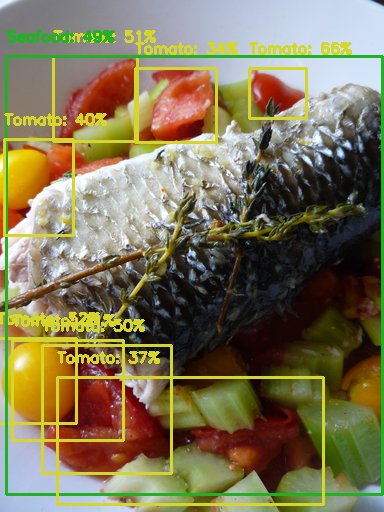

In [11]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## (Optional) Compile For the Edge TPU

Now that you have a quantized EfficientDet Lite model, it is possible to compile and deploy to a [Coral EdgeTPU](https://coral.ai/).

**Step 1. Install the EdgeTPU Compiler**

In [12]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k


OK


deb https://packages.cloud.google.com/apt coral-edgetpu-stable main


Hit:1 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:3 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-backports InRelease
0% [1 InRelease gpgv 242 kB] [Connecting to security.ubuntu.com (91.189.88.142)

Hit:4 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease
Get:5 https://nvidia.github.io/nvidia-container-runtime/ubuntu18.04/amd64  InRelease [1481 B]
Get:6 https://nvidia.github.io/nvidia-docker/ubuntu18.04/amd64  InRelease [1474 B]
0% [2 InRelease gpgv 88.7 kB] [Connecting to security.ubuntu.com (91.189.88.142

Ign:7 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
0% [3 InRelease gpgv 74.6 kB] [Connecting to security.ubuntu.com (91.189.88.142

0% [4 InRelease gpgv 1484 B] [Waiting for headers] [Waiting for headers] [Waiti

Get:9 http://packages.cloud.google.com/apt google-cloud-logging-wheezy InRelease [5483 B]
0% [5 InRelease gpgv 1481 B] [Waiting for headers] [Waiting for headers] [Waiti

0% [6 InRelease gpgv 1474 B] [Waiting for headers] [Waiting for headers] [Waiti

Hit:10 http://archive.canonical.com/ubuntu bionic InRelease
Hit:11 http://security.ubuntu.com/ubuntu bionic-security InRelease
0% [6 InRelease gpgv 1474 B] [Waiting for headers]

0% [Release.gpg gpgv 564 B] [Waiting for headers]

0% [9 InRelease gpgv 5483 B] [Waiting for headers]

Get:13 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6722 B]
0% [9 InRelease gpgv 5483 B]

0% [10 InRelease gpgv 10.2 kB] [Waiting for headers]

0% [11 InRelease gpgv 88.7 kB] [Waiting for headers]

0% [13 InRelease gpgv 6722 B] [Waiting for headers]

0% [Waiting for headers]

Get:14 https://packages.cloud.google.com/apt eip-cloud-bionic InRelease [5419 B]
Ign:15 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages
0% [14 InRelease gpgv 5419 B]

92% [Waiting for headers]

Get:15 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [2327 B]
Fetched 22.9 kB in 1s (18.7 kB/s)


The following packages were automatically installed and are no longer required:
  linux-gcp-5.4-headers-5.4.0-1040 linux-gcp-5.4-headers-5.4.0-1043
  linux-gcp-5.4-headers-5.4.0-1044 linux-gcp-5.4-headers-5.4.0-1049
  linux-headers-5.4.0-1049-gcp linux-image-5.4.0-1049-gcp
  linux-modules-5.4.0-1044-gcp linux-modules-5.4.0-1049-gcp
  linux-modules-extra-5.4.0-1049-gcp
Use 'sudo apt autoremove' to remove them.


The following NEW packages will be installed:
  edgetpu-compiler
0 upgraded, 1 newly installed, 0 to remove and 119 not upgraded.
Need to get 7913 kB of archives.
After this operation, 31.2 MB of additional disk space will be used.
0% [Working]

Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 edgetpu-compiler amd64 16.0 [7913 kB]
0% [1 edgetpu-compiler 0 B/7913 kB 0%]

42% [1 edgetpu-compiler 4194 kB/7913 kB 53%]

Fetched 7913 kB in 1s (11.2 MB/s)


Selecting previously unselected package edgetpu-compiler.


(Reading database ... 283192 files and directories currently installed.)
Preparing to unpack .../edgetpu-compiler_16.0_amd64.deb ...
Unpacking edgetpu-compiler (16.0) ...


Setting up edgetpu-compiler (16.0) ...


Processing triggers for libc-bin (2.27-3ubuntu1.2) ...


**Step 2. Select number of Edge TPUs, Compile**

The EdgeTPU has 8MB of SRAM for caching model paramaters ([more info](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)). This means that for models that are larger than 8MB, inference time will be increased in order to transfer over model paramaters. One way to avoid this is [Model Pipelining](https://coral.ai/docs/edgetpu/pipeline/) - splitting the model into segments that can have a dedicated EdgeTPU. This can significantly improve latency.

The below table can be used as a reference for the number of Edge TPUs to use - the larger models will not compile for a single TPU as the intermediate tensors can't fit in on-chip memory.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

In [13]:
NUMBER_OF_TPUS =  1#@param {type:"number"}

!edgetpu_compiler model.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.



Model compiled successfully in 4410 ms.

Input model: model.tflite
Input size: 4.24MiB
Output model: model_edgetpu.tflite
Output size: 5.61MiB
On-chip memory used for caching model parameters: 4.24MiB
On-chip memory remaining for caching model parameters: 3.27MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


**Step 3. Download, Run Model**

With the model(s) compiled, they can now be run on EdgeTPU(s) for object detection. First, download the compiled TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model_edgetpu.tflite` file and choose `Download` to download it to your local computer.

Now you can run the model in your preferred manner. Examples of detection include:
* [pycoral detection](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py)
* [Basic TFLite detection](https://github.com/google-coral/tflite/tree/master/python/examples/detection)
* [Example Video Detection](https://github.com/google-coral/examples-camera)
* [libcoral C++ API](https://github.com/google-coral/libcoral)


## Advanced Usage

This section covers advanced usage topics like adjusting the model and the training hyperparameters.

### Load the dataset

#### Load your own data

You can upload your own dataset to work through this tutorial. Upload your dataset by using the left sidebar in Colab.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_object_detection.png" alt="Upload File" width="1000" hspace="0">

If you prefer not to upload your dataset to the cloud, you can also locally run the library by following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

#### Load your data with a different data format

The Model Maker library also supports the `object_detector.DataLoader.from_pascal_voc` method to load data with [PASCAL VOC](https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5#:~:text=Pascal%20VOC%20is%20an%20XML,for%20training%2C%20testing%20and%20validation) format. [makesense.ai](https://www.makesense.ai/) and [LabelImg](https://github.com/tzutalin/labelImg) are the tools that can annotate the image and save annotations as XML files in PASCAL VOC data format:
```python
object_detector.DataLoader.from_pascal_voc(image_dir, annotations_dir, label_map={1: "person", 2: "notperson"})
```


### Customize the EfficientDet model hyperparameters

The model and training pipline parameters you can adjust are:

* `model_dir`: The location to save the model checkpoint files. If not set, a temporary directory will be used.
* `steps_per_execution`: Number of steps per training execution.
* `moving_average_decay`: Float. The decay to use for maintaining moving averages of the trained parameters.
* `var_freeze_expr`: The regular expression to map the prefix name of variables to be frozen which means remaining the same during training. More specific, use `re.match(var_freeze_expr, variable_name)` in the codebase to map the variables to be frozen.
* `tflite_max_detections`: integer, 25 by default. The max number of output detections in the TFLite model.
* `strategy`:  A string specifying which distribution strategy to use. Accepted values are 'tpu', 'gpus', None. tpu' means to use TPUStrategy. 'gpus' mean to use MirroredStrategy for multi-gpus. If None, use TF default with OneDeviceStrategy.
* `tpu`:  The Cloud TPU to use for training. This should be either the name used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 url.
* `use_xla`: Use XLA even if strategy is not tpu. If strategy is tpu, always use XLA, and this flag has no effect.
* `profile`: Enable profile mode.
* `debug`: Enable debug mode.

Other parameters that can be adjusted is shown in [hparams_config.py](https://github.com/google/automl/blob/df451765d467c5ed78bbdfd632810bc1014b123e/efficientdet/hparams_config.py#L170).


For instance, you can set the `var_freeze_expr='efficientnet'` which freezes the variables with name prefix `efficientnet` (default is `'(efficientnet|fpn_cells|resample_p6)'`). This allows the model to freeze untrainable variables and keep their value the same through training.

```python
spec = model_spec.get('efficientdet_lite0')
spec.config.var_freeze_expr = 'efficientnet'
```

### Change the Model Architecture

You can change the model architecture by changing the `model_spec`. For instance, change the `model_spec` to the EfficientDet-Lite4 model.

```python
spec = model_spec.get('efficientdet_lite4')
```

### Tune the training hyperparameters

The `create` function is the driver function that the Model Maker library uses to create models. The `model_spec` parameter defines the model specification. The `object_detector.EfficientDetSpec` class is currently supported. The `create` function comprises of the following steps:

1. Creates the model for the object detection according to `model_spec`.
2. Trains the model.  The default epochs and the default batch size are set by the `epochs` and `batch_size` variables in the `model_spec` object.
You can also tune the training hyperparameters like `epochs` and `batch_size` that affect the model accuracy. For instance,

*   `epochs`: Integer, 50 by default. More epochs could achieve better accuracy, but may lead to overfitting.
*   `batch_size`: Integer, 64 by default. The number of samples to use in one training step.
*   `train_whole_model`: Boolean, False by default. If true, train the whole model. Otherwise, only train the layers that do not match `var_freeze_expr`.

For example, you can train with less epochs and only the head layer. You can increase the number of epochs for better results.

```python
model = object_detector.create(train_data, model_spec=spec, epochs=10, validation_data=validation_data)
```

### Export to different formats

The export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`




By default, it exports only the TensorFlow Lite model file containing the model [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use in an on-device ML application. The label file is embedded in metadata.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you quantize the model to make it smaller and potentially run faster. As for EfficientDet-Lite models, full integer quantization  is used to quantize the model by default. Please refer to [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) for more detail.

```python
model.export(export_dir='.')
```

You can also choose to export other files related to the model for better examination. For instance, exporting both the saved model and the label file as follows:
```python
model.export(export_dir='.', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])
```

### Customize Post-training quantization on the TensorFlow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

```python
config = QuantizationConfig.for_float16()
```


Then we export the TensorFlow Lite model with such configuration.

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

# Read more

You can read our [object detection](https://www.tensorflow.org/lite/examples/object_detection/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/guide/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ObjectDetector](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

